# 4.1. Experiments on training with MMD only on synthetic target data
During this set of experiments we will train the full working pipeline using the Unity subprocess running in the background. The pipeline will only be trained using the Maximum Mean Discrepancy loss, in the hopes that the architecture will learn to fit a random distribution to a fixed distribution. These two distributions will be synthetic RGB images of 128x128 pixel resolution. We initially fit a synthetic target distribution so we can get rid of any randomness in the data that hinders Meta-Sim's ability to fit a target distribution. This way we can make sure that Meta-Sim can fit an initial simple target distribution.
## 4.1.1. Learning to rotate an object 90 degrees on a single-class setting
In our case, the random distribution will be a set of images from an object in a Unity 3D scene rotated according to a prior normal distribution of arbitrary parameters, and the fixed (target) distribution will be a set of images from the same object in the 3D scene rotated 90 degrees. The graph representation of the probabilistic grammar used for this set of experiments is shown below _show graph figure of probabilistic grammar_.

#### Library imports
Let us import all relevant libraries to analyse our results from each of the experiments.

In [1]:
import pandas as pd
import cv2
import random
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from tqdm import tqdm_notebook as tqdm

### Helper functions
Let us define all the functions that will help in this study.

#### General helper functions

In [68]:
ROOT_PATH = '../results'
PROG_PATH = 'progress'
GRAPH_PATH = 'graphs'
DIST_PATH = 'images'
FMAP_PATH = 'feature_maps'
TGT_PATH = 'images/target'
gen_PATH = '../data/datagen/scenes/unity/3d_scene_tgt/Builds/3dv1_Data/StreamingAssets/Snapshots'
GRAD_PATH = 'gradients'

# General helper functions
def import_npy(file_name):
    return np.load(file_name)

def import_json(file_name):
    with open(file_name, 'r') as f:
        config = json.load(f)
    
    return config

def import_csv(file_name):
    return pd.read_csv(file_name)

def import_png(file_name):
    img = cv2.imread(file_name)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def walk_npy_folder(directory):
    npys = []
    if os.path.isdir(directory):
        for filename in os.listdir(directory):
            if filename.endswith('.npy'):
                npy = import_npy(os.path.join(directory, filename))
                npys.append(npy)
        
        return np.array(npys)
    
    else:
        return np.empty((1,1))

def walk_json_folder(directory):
    jsons = []
    if os.path.isdir(directory):
        for filename in os.listdir(directory):
            if filename.endswith('.json'):
                json_ = import_json(os.path.join(directory, filename))
                jsons.append(json_)
        
        return jsons
    
    else:
        return []

def walk_png_folder(directory, n_samples):
    pngs = []
    random_sample = random.randint(0, n_samples)
    if os.path.isdir(directory):
        for filename in os.listdir(directory):
            if filename.endswith('.png'):
                file_n = int(filename.split('.')[0])
                if file_n == random_sample: 
                    png = import_png(os.path.join(directory, filename))
                    pngs.append(png)
        
        return pngs
    
    else:
        return []

def read_yaml(fname):
    with open(fname, 'r') as f:
        config = yaml.safe_load(f)

    return config

def read_hyperaparameters(experiment_n):
    hpams_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', 'hyperparameters', f'experiment{experiment_n}_hyperparameters.yaml')
    return read_yaml(hpams_path)

def pca_array(array, components=None):
    pca = PCA(n_components=components)
    return pca.fit_transform(array)

def jitter(values, std):
    return values + np.random.normal(np.mean(values),std)

def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

#### GCN helper functions

In [37]:
# GCN helper functions
def get_GCN_progress(experiment_n):
    progress_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', PROG_PATH)
    return import_csv(os.path.join(progress_path, 'gcn.csv'))

def plot_pretraining_progress(experiment_n):
    progress_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', PROG_PATH)
    gcn_progres = import_csv(os.path.join(progress_path, 'gcn.csv'))
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(15,5))
    plt.plot(gcn_progres['rec_epoch'], gcn_progres['class_loss'], label='class loss')
    plt.plot(gcn_progres['rec_epoch'], gcn_progres['cont_loss'], label='cont loss')
    plt.plot(gcn_progres['rec_epoch'], gcn_progres['loss'], label='(total) loss')
    plt.legend(fontsize=12)
    plt.title("GCN pre-training loss", fontweight='bold', fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Losses", fontsize=12)

def get_epoch_graphs(graph_path, epoch):
    graph_epoch_path = os.path.join(graph_path, f'epoch_{epoch}')
    return walk_npy_folder(graph_epoch_path)

def get_feature_graphs(experiment_n, dimension, interv):
    graph_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', GRAPH_PATH)
    hpams = read_hyperaparameters(experiment_n)
    total_epochs = hpams['max_epochs']
    freq = hpams['distprint_freq']
    interval = interv

    feature_dict = {}
    for e in range(0, total_epochs+1, freq*interval):
        graph_features = get_epoch_graphs(graph_path, e)
        if len(graph_features) > 1:
            graph_features = np.reshape(graph_features, \
                (graph_features.shape[0]*graph_features.shape[1], graph_features.shape[2]))
            feature_dict[f'epoch_{e}'] =  pca_array(graph_features, \
                                                    components=dimension).T
            
        else:
            print("Full results not ready yet")
            break

    return feature_dict

def plot_gfeature_representation(experiment, components, interval):
    # Get all graph features in 3D representation
    graph_features = get_feature_graphs(experiment_n=experiment, dimension=components, interv=interval)

    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})

    dim = len(graph_features)
    fig = plt.figure(figsize = (dim*5, (dim*5)/dim))
    plt.suptitle("Graph batch node feature representation", fontweight="bold", y=1.05)
    for i, epoch in enumerate(graph_features.keys()):
        # Get epoch's data
        node_features = graph_features[epoch]
        epoch = int(epoch.split('_')[-1])
        # Create figure
        # Creating plot
        if node_features.shape[0] == 3:
            ax = fig.add_subplot(1, dim, i+1, projection='3d')
            ax.scatter3D(node_features[0], node_features[1], node_features[2],\
                color = 'lightseagreen', s=40, edgecolors='white', linewidths=0.8, alpha=0.0025)
            plt.title(f"epoch {epoch}")

        else:
            ax = fig.add_subplot(1, dim, i+1)
            ax.scatter(node_features[0], node_features[1],\
                color = 'lightseagreen', s=40, edgecolors='white', linewidths=0.8, alpha=0.0025)
            plt.title(f"epoch {epoch}")
    plt.tight_layout()

#### Feature maps helper functions

In [71]:
# Feature maps helper functions
def TSNE_fmaps(n_components, concat_array):
    components=n_components
    embedded = TSNE(n_components=components).fit_transform(concat_array).T

    return embedded

def get_e_fmaps_inception(fmap_folder, epoch_n, n_components):
    fmap_epoch_folder = os.path.join(fmap_folder, f'epoch_{epoch_n}', 'fmaps_2048')
    gen_tgt_dict = {'gen':[], 'tgt':[]}
    if os.path.isdir(fmap_epoch_folder):
        for filename in os.listdir(fmap_epoch_folder):
            if filename.endswith('.npy'):
                splitfname = filename.split('_')
                tgt_gen = splitfname[1]
                fmap_n = splitfname[0][-1]
                if tgt_gen == 'gen':
                    npy = import_npy(os.path.join(fmap_epoch_folder, filename))
                    gen_tgt_dict['gen'].append(npy)
                else:
                    npy = import_npy(os.path.join(fmap_epoch_folder, filename))
                    gen_tgt_dict['tgt'].append(npy)
        
        # Concatenate collected fmaps
        gen_tgt_dict['gen'] = TSNE_fmaps(n_components, np.concatenate(gen_tgt_dict['gen']))
        gen_tgt_dict['tgt'] = TSNE_fmaps(n_components, np.concatenate(gen_tgt_dict['tgt']))
    
    else:
        pass
    
    return gen_tgt_dict

def get_epoch_fmaps(experiment_n, interv, n_components):
    fmap_folder = os.path.join(ROOT_PATH, f'experiment{experiment_n}', FMAP_PATH)
    hpams = read_hyperaparameters(experiment_n)
    total_epochs = hpams['max_epochs']
    freq = hpams['distprint_freq']
    interval = interv

    fmaps_dict = {}
    for e in range(0, total_epochs+1, freq*interval):
        fmaps = get_e_fmaps_inception(fmap_folder, e, n_components)
        if type(fmaps['gen']) != list:
            fmaps_dict[f'epoch_{e}'] = fmaps
            
        else:
            print("Full results not ready yet")
            break

    return fmaps_dict

def plot_feature_representation(experiment, components, interval):
    # Get all graph features in 3D representation
    fmap_features = get_epoch_fmaps(experiment, interval, components)
    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})

    dim = len(fmap_features)
    fig = plt.figure(figsize = (dim*5, (dim*5)/dim))
    plt.suptitle("Inception feature maps", fontweight="bold", y=1.05)
    for i, epoch in enumerate(fmap_features.keys()):
        # Create figure
        if components == 3:
            ax = fig.add_subplot(1, dim, i+1, projection='3d')
            # Get components
            x_tgt, y_tgt, z_tgt = fmap_features[epoch]['tgt'][0],fmap_features[epoch]['tgt'][1],fmap_features[epoch]['tgt'][2]
            x_gen, y_gen, z_gen = fmap_features[epoch]['gen'][0],fmap_features[epoch]['gen'][1],fmap_features[epoch]['gen'][2]

            std_jitter = 0.001
            # Creating plot
            ax.scatter3D(jitter(x_tgt, std_jitter), jitter(y_tgt, std_jitter), jitter(z_tgt,std_jitter) , color = "green", label='Target', alpha=0.25)
            ax.scatter3D(jitter(x_gen,std_jitter), jitter(y_gen,std_jitter), jitter(z_gen,std_jitter) , color = "blue", label='Generated', alpha=0.25)
            plt.title(epoch)
            plt.legend()

        else:
            # Get components
            x_tgt, y_tgt= fmap_features[epoch]['tgt'][0],fmap_features[epoch]['tgt'][1]
            x_gen, y_gen= fmap_features[epoch]['gen'][0],fmap_features[epoch]['gen'][1]
            # Normalize components
            x_tgt, y_tgt = scale_to_01_range(x_tgt), scale_to_01_range(y_tgt)
            x_gen, y_gen = scale_to_01_range(x_gen), scale_to_01_range(y_gen)
            std_jitter = 0.0001
            # Creating plot
            ax = fig.add_subplot(1, dim, i+1)
            ax.scatter(jitter(x_tgt, std_jitter), jitter(y_tgt, std_jitter), color = "green", label='Target', alpha=0.25)
            ax.scatter(jitter(x_gen,std_jitter), jitter(y_gen,std_jitter), color = "blue", label='Generated', alpha=0.25)
            plt.title(epoch)
            plt.legend()

    plt.tight_layout()

#### Distribution helper functions

In [69]:
# Distribution helper functions
def get_epoch_dist(dist_path, epoch):
    dist_epoch_path = os.path.join(dist_path, f'epoch_{epoch}')
    return walk_json_folder(dist_epoch_path)

def get_epoch_imgs(imgs_path, epoch, max_samples):
    imgs_epoch_path = os.path.join(imgs_path, f'epoch_{epoch}')
    return walk_png_folder(imgs_epoch_path, max_samples)

def get_distributions(experiment_n, interv):
    graph_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', DIST_PATH)
    hpams = read_hyperaparameters(experiment_n)
    total_epochs = hpams['max_epochs']
    freq = hpams['distprint_freq']
    interval = interv

    dist_dict = {}
    for e in range(0, total_epochs+1, freq*interval):
        dist_samples = get_epoch_dist(graph_path, e)
        if len(dist_samples) > 1:
            dist_dict[f'epoch_{e}'] = [dist_sample['yaw'] for dist_sample in dist_samples]
            
        else:
            print("Full results not ready yet")
            break
    
    return dist_dict

def get_tgt_distribution(experiment_n):
    tgt_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', TGT_PATH)
    tgt_dist_dict = walk_json_folder(tgt_path)
    return {'tgt_dist':[tgt['yaw'] for tgt in tgt_dist_dict]}

def get_tgt_image(max_tgt_samples, experiment_n):
    tgt_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', TGT_PATH)
    tgt_image = walk_png_folder(tgt_path, max_tgt_samples)
    return tgt_image[0]

def get_gen_images(experiment_n, interv):
    imgs_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', DIST_PATH)
    hpams = read_hyperaparameters(experiment_n)
    total_epochs = hpams['max_epochs']
    freq = hpams['distprint_freq']
    max_samples = hpams['epoch_length']
    max_tgt_samples = hpams['num_real_images']
    interval = interv

    imgs_dict = {}
    for e in range(0, total_epochs+1, freq*interval):
        dist_samples = get_epoch_imgs(imgs_path, e, max_samples)
        if len(dist_samples) == 1:
            imgs_dict[f'epoch_{e}'] = dist_samples[0]
            
        else:
            print("Full results not ready yet")
            break
    
    # Add target image
    imgs_dict['Target image'] = get_tgt_image(max_tgt_samples, experiment_n)
    return imgs_dict

def plot_distributions(experiment, interval):
    # Get target distribution
    tgt_dist_dict = get_tgt_distribution(experiment)
    # Get target distributions
    dist_dict = get_distributions(experiment, interval)
    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

    fig = plt.figure(figsize = (20, 5))
    colors = []
    # Plot generated distributions
    for epoch_n in dist_dict.keys():
        e = int(epoch_n.split('_')[-1]) 
        angles = dist_dict[epoch_n]
        if np.mean(angles) < 0.1:
            angles = list(np.array(angles))

        hist,edges = np.histogram(angles, bins=20)
        bin_centers = 0.5*(edges[:-1] + edges[1:])
        bin_widths = (edges[1:]-edges[:-1])
        plt.bar(bin_centers,hist,width=bin_widths, label=epoch_n, joinstyle='bevel')
        plot = plt.plot(bin_centers, hist, linewidth=3)
        colors.append(plot[0].get_color())

    # Plot target distribution
    tgt_angles = tgt_dist_dict['tgt_dist']    
    #tgt_angles = list(np.array(tgt_angles)+ np.random.normal(0,0.1,np.array(tgt_angles).shape))

    hist,edges = np.histogram(tgt_angles, bins=20)
    bin_centers = 0.5*(edges[:-1] + edges[1:])
    bin_widths = (edges[1:]-edges[:-1])

    plt.bar(bin_centers,hist,width=bin_widths, color='salmon', alpha=0.7, label='Target dist.', joinstyle='bevel')
    plot = plt.plot(bin_centers, hist, linewidth=3, color='salmon', alpha=0.7)
    colors.append(plot[0].get_color())
    # Finalize plot
    plt.title("Produced angles distribution", fontweight='bold')
    plt.legend(loc='upper right')
    plt.xlabel('angle [$^\circ$]')
    plt.ylabel('frequency')
    plt.show()

    return colors

def plot_each_distribution(experiment, interval):
    # Plot joint plot and get colors
    colors = plot_distributions(experiment, interval)
    # Get target distribution
    tgt_dist_dict = get_tgt_distribution(experiment)
    # Get target distributions
    dist_dict = get_distributions(experiment, interval)
    dist_dict['Target dist'] = tgt_dist_dict['tgt_dist']
    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

    dim = len(dist_dict)
    fig = plt.figure(figsize = (dim*5, (dim*5)/dim))
    plt.suptitle("Generated distributions at each key epoch", fontweight="bold", y=1.05)
    # Plot generated distributions
    for i, epoch_n in enumerate(dist_dict.keys()):
        ax = fig.add_subplot(1, dim, i+1)
        angles = dist_dict[epoch_n]
        hist,edges = np.histogram(angles, bins=20)
        bin_centers = 0.5*(edges[:-1] + edges[1:])
        bin_widths = (edges[1:]-edges[:-1])

        ax.bar(bin_centers,hist,width=bin_widths, alpha=0.7, label=epoch_n, color=colors[i], joinstyle='bevel')
        ax.plot(bin_centers, hist, linewidth=1, color= colors[i], alpha=0.7)

        # Finalize plot
        plt.title(f"{epoch_n}")
        plt.xlabel('angle [$^\circ$]')
    
    plt.ylabel('frequency')
    plt.show()

def plot_each_image(experiment, interval):
    # Get target distribution
    epoch_images = get_gen_images(experiment, interval)

    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

    dim = len(epoch_images)
    fig = plt.figure(figsize = (dim*5, (dim*5)/dim))
    plt.suptitle("Random sample of generated images at each key epoch", fontweight="bold", fontsize=16, y=1.1)
    # Plot generated distributions
    for i, epoch_n in enumerate(epoch_images.keys()):
        ax = fig.add_subplot(1, dim, i+1)
        ax.imshow(epoch_images[epoch_n])
        # Finalize plot
        plt.title(f"{epoch_n}", fontsize=16)
        plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
    plt.tight_layout()
    plt.show()

#### Gradients and MMD helper functions

In [79]:
# Gradients and MMD helper functions
def plot_MMD_loss(experiment_n):
    progress_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', PROG_PATH)
    gcn_progres = import_csv(os.path.join(progress_path, 'mmd.csv'))
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12,6))
    plt.plot(gcn_progres['epoch'], gcn_progres['mmd_loss'], label='MMD loss')
    plt.legend(fontsize=12)
    plt.title(f"MMD loss after training", fontweight='bold', fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.show()

def plot_gradients(experiment_n):
    gradient_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', GRAD_PATH)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(15,5))
    for epoch in range(0, 11, 5):
        epoch_grad_path = os.path.join(gradient_path, f'grads_e_{epoch}.csv') 
        epoch_grad_df = pd.read_csv(epoch_grad_path)
        layer_names = ['_'.join(layer_name.split('.')[:]) for layer_name in epoch_grad_df['layer']]
        batches = list(epoch_grad_df.columns[1:])
        # change slice to 23 when not wanting to print encoder gradients
        slice_ = 23
        plt.plot(layer_names[slice_:], epoch_grad_df[slice_:].sum(axis=1), \
            color='teal', alpha=(1-(0.02*epoch)), label=f'Epoch {epoch}')
        plt.xticks(rotation=90)
    plt.title("GCN decoder gradient flow", fontweight='bold')
    plt.legend()
    plt.show()

### 4.1.1.1. Fitting a dirac target distribution with the same configuration than MNIST, but on our Unity 3D scene
The first experiment we will conduct will be training the Meta-Sim architecture only on MMD with the same hyperparameters as the previous MNIST experiments (see section 3.2.2.), but adapted for the Unity renderer to generate images of a given 3D scene. The hyperparaemters for all the experiments are explained in detail in Appendix X. However, it is important to note that in the following experiment we will only use the last fully connected layer of the Inception network to compare the generated distribution to the target distribution using MMD.

### Graph Convolutional Network performance
According to the methodology define in section 3.4, we start by analyzing (1) the GCN's performance during its pre-training phase, and (2) how the graphs are being reproduced as the network trains. This will allow us to understand (1) if the GCN's pre-training is affecting the downstream performance of the network at fitting a target distribution, and (2) if the feature representation of the network is evolving towards a fixed distribution.

#### GCN pretraining progress

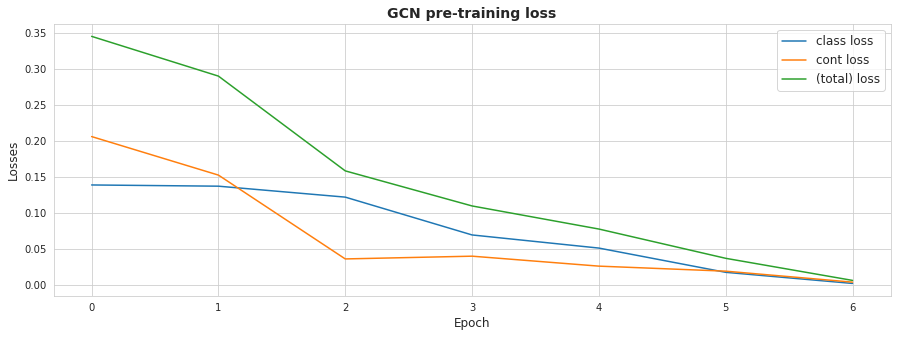

In [17]:
# Plot loss
plot_pretraining_progress(1)

From these results we can see that the same behavior as in the MNIST case is observed. The architecture learns how to classify each node (class loss), and how to construct the value of each node (cont loss). The total loss is the sum of both losses. The value converges to a low of under ~0.05. We will pay close attention to this value, since it could be the case that the pre-training of the architecture on such a simple graph is harmful to the learning during the MMD training stages.

After the pre-training stage, we train the architecture for 500 epochs with the task of fitting a dirac distribution on 90 degrees.

#### Per epoch graph feature representation

As per the probabilistic grammar shown above, we observe that there are 4 definite nodes, out of which all attributes are mutable, except for the _yaw_ attribute which is mutable on the 3rd node belonging to the object node. As explained before, the GCN learns to reproduce a featurized representation of the graphs sampled from the probabilistic grammar. This featurized representation is reproduced by batches of size _batch\_sizexnodes\_numberxfeatures\_number_. We can therefore grab those matrices and map them to a lower dimensional space using PCA (_provide citation_), and observe how each node is represented. We can further plot how this representation evolves every 100 epochs in the training.

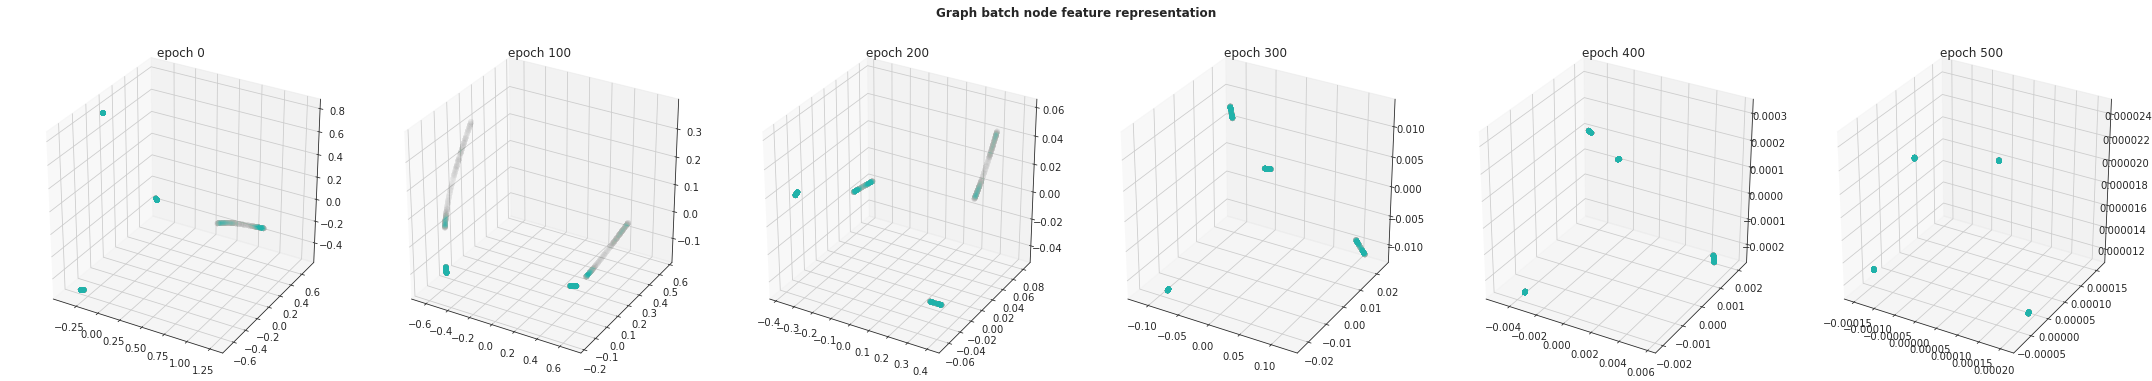

In [45]:
# Plot feature representation
plot_gfeature_representation(experiment=1, components=3, interval=4)

From this plot we can observe an initial desired behavior in epoch 0, where 3 nodes are static in space, and the 4th one varies. We assume this node is the one belonging to the object with the modifiable attribute yaw. As the architecture evolves and learns, we would hope to see the 4th node vary, and the rest remain static, until convergence is reached and the target distribution is learned.

This however is not the case, from epoch 200 to epoch 400, the 4 nodes move along the space with no aparent pattern, to finally remain static at epoch 500. We further investigate the evolution of the generated distribution in the following study.

### Distribution of generated samples
We now focus on understanding how the generated _yaw_ value samples from the trained GCN change as it is trained only on the MMD loss. We further compare these to the target distribution, to understand how the generated distribution is shifting with repect to the target, given that the graph feature representations were not behaving as expected.

#### Distribution of generated angles

We plot the distributions below every 100 epochs, to understand how they are shifting as the architecture trains.

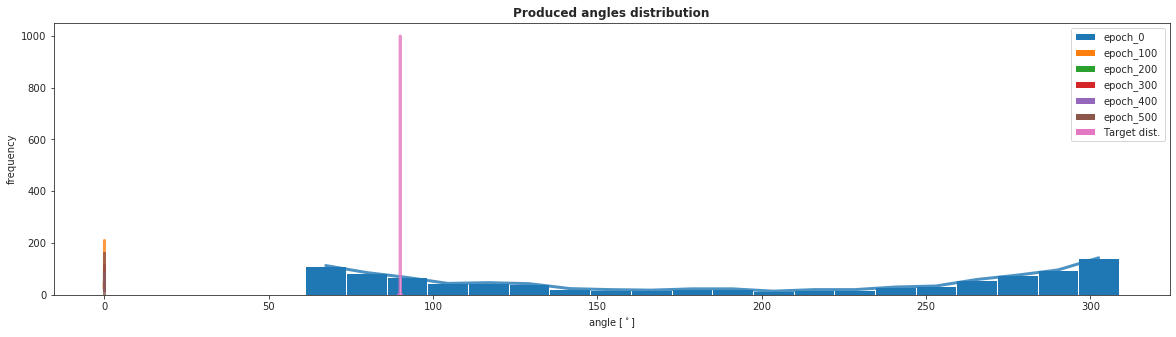

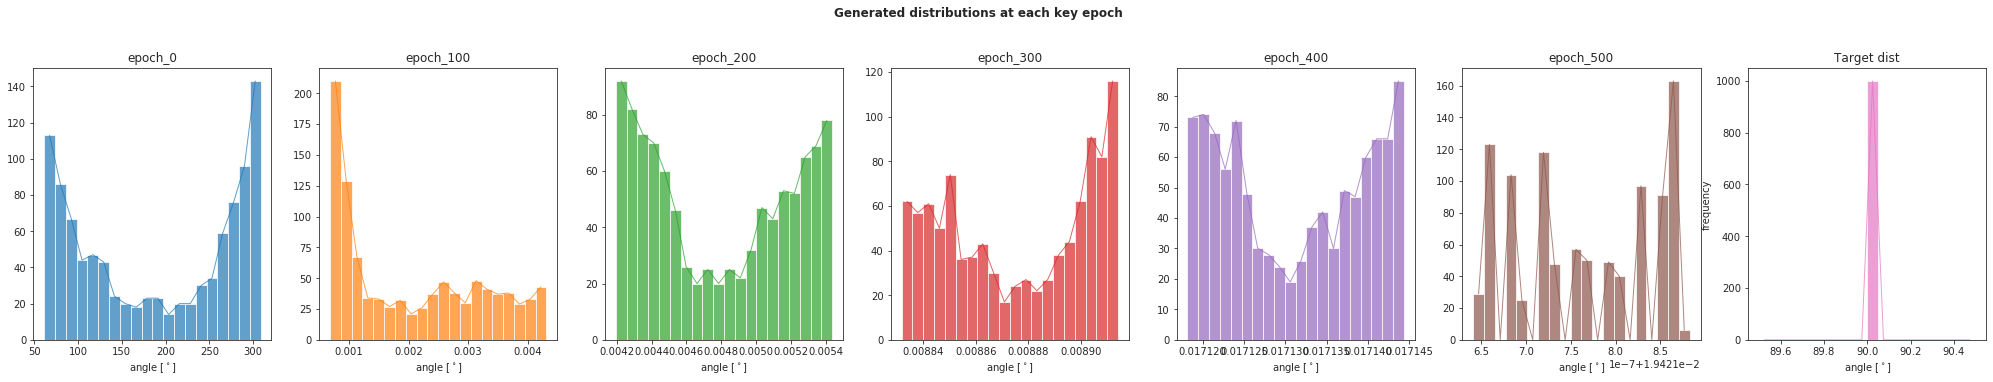

In [10]:
plot_each_distribution(experiment=1, interval=4)

From the plots we can see that the target distribution is indeed a dirac impulse at 90 degrees. And the other generated distributions are collapsing to angles very close to 0. We can also observe some kind of shifted normal distribution. After further investigation the initial grammar was defined with the yaw parameter as a Gaussian centered around 0 degrees, with standard deviation of 90 degrees, and maximum value of 360 degrees. After sampling, the architecture takes the modulus of the sampled value and the maximum value

$$yaw  = modulus(sample_yaw, max_value) $$

According to this, any negative value will be mapped to a the positive remainder between the value and the maximum value. This indeed inverts the distribution.

#### Generated images at each key epoch

According to the previous distributions, if we observe a randomly sampled generated image, and we compare them to the target, we can see that the architecture is not learning to generate any rotations.

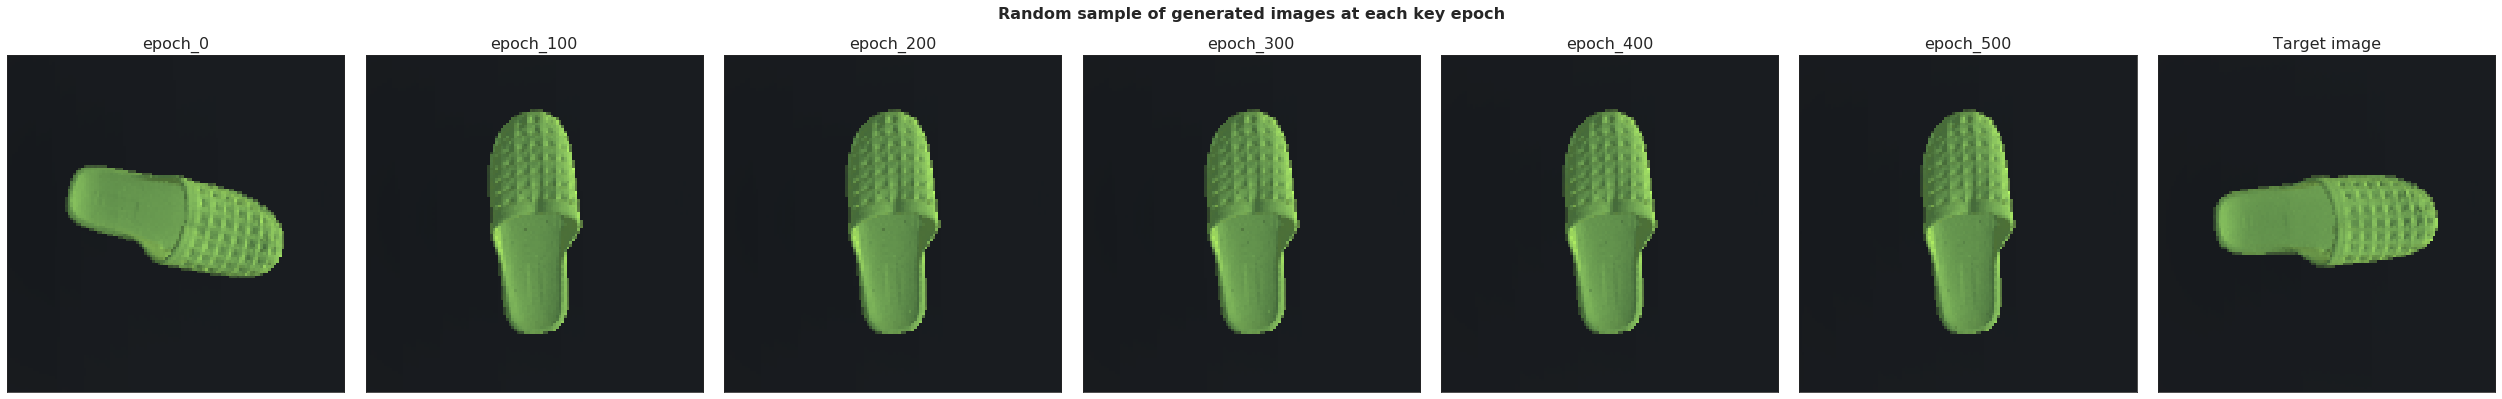

In [50]:
plot_each_image(experiment=1, interval=4)

### Distribution of Inception feature maps
Without looking at the behavior of the MMD loss, we can now conclude that the architecture is not learning. Even if the loss was not converging, or if it were random, we have to look at the generated distributions to observe how they compare to the target distribution. We can further do this by plotting the feature maps generated by the Inception network, by pllotting them to a shared space using T-SNE (_provide citation_). 

#### Per epoch feature representation in 2D

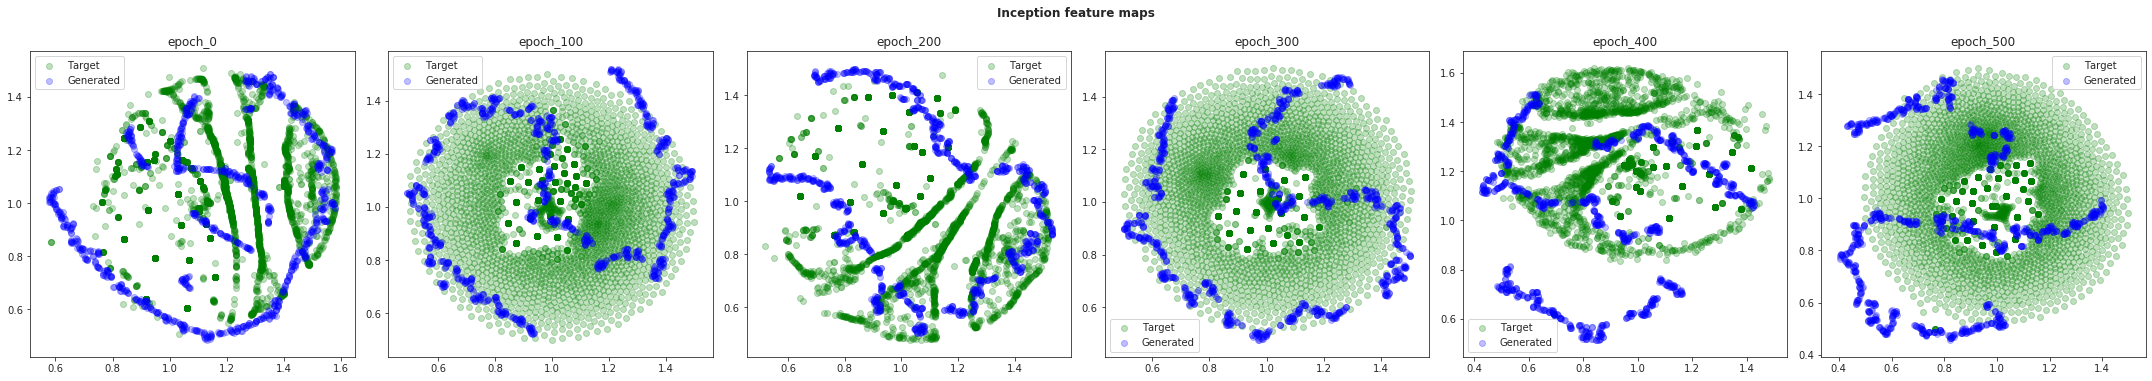

In [18]:
plot_feature_representation(experiment=1, components=2, interval=4)

#### Per epoch feature representation in 3D

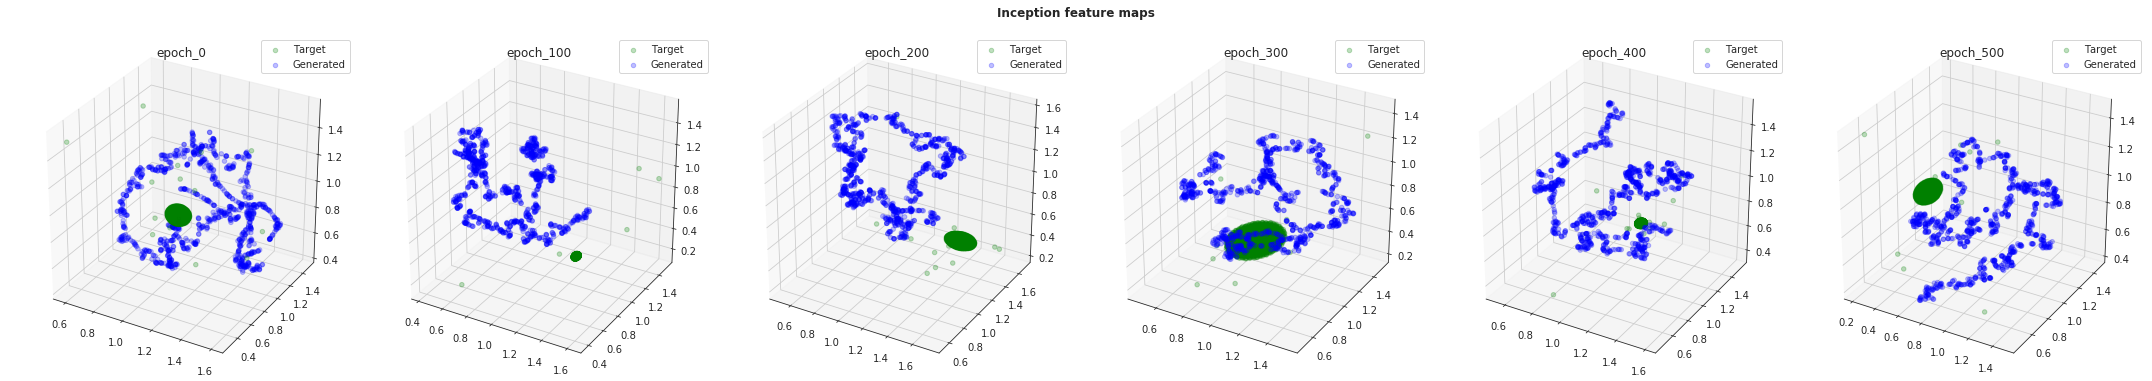

In [19]:
plot_feature_representation(experiment=1, components=3, interval=4)

From these distributions we can see that the generated distribution is still incompatible with the target distribution.

### Maximum Mean Discrepancy loss and gradient behavior
As we have seen from the previous results, the network doesn't seem to be learning to fit a target distribution. It seems to be suffering from node collapse (_check citation_), which hints that the learning is getting stuck in local minima. Let us confirm this by looking at the MMD loss behavior through the epochs, and the gradient flow of every batch, at every epoch.

#### Maximum Mean Discrepancy loss behavior

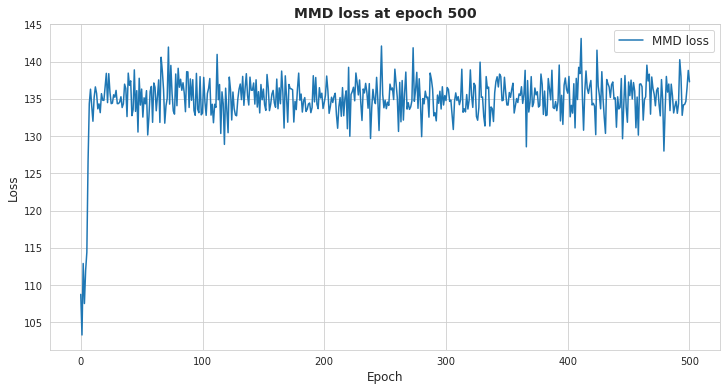

In [178]:
plot_MMD_loss(1)

#### Gradient flow through GCN

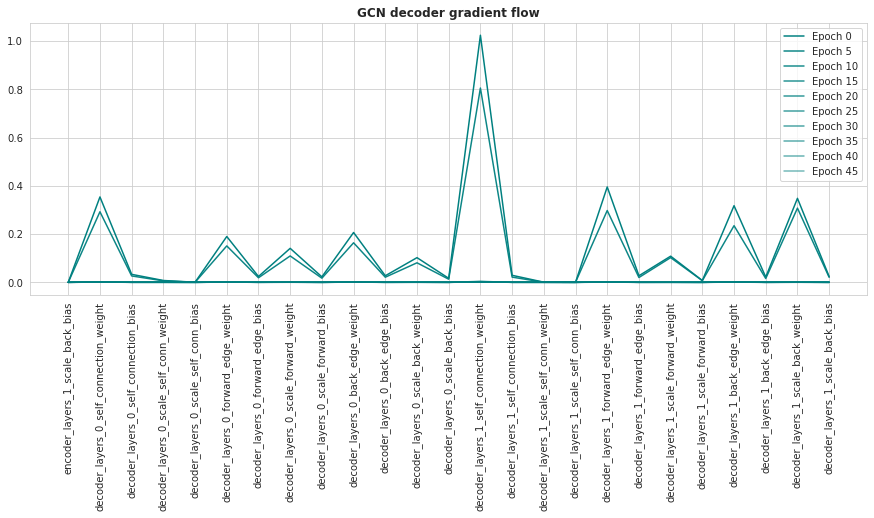

In [26]:
plot_gradients(experiment_n=1)

Indeed, we can see that after 5 epochs, the gradients are always practically 0 in the decoder part of our GCN network, at every one of its layers. This is a clear sign that the architecture is not learning anymore, and it is just stuck in a local optimum.

### 4.1.1.2. Fitting a Gaussian ditribution with the same configuration than MNIST, but on our Unity 3D scene
Since the dirac target distribution forces mode collapse in the network's training, we will address this by having a normal distribution of mean 90 degrees, and standard deviation 10 degrees, as our target distribution. We will run this experiment for 100 epochs.

### Graph Convolutional Network performance

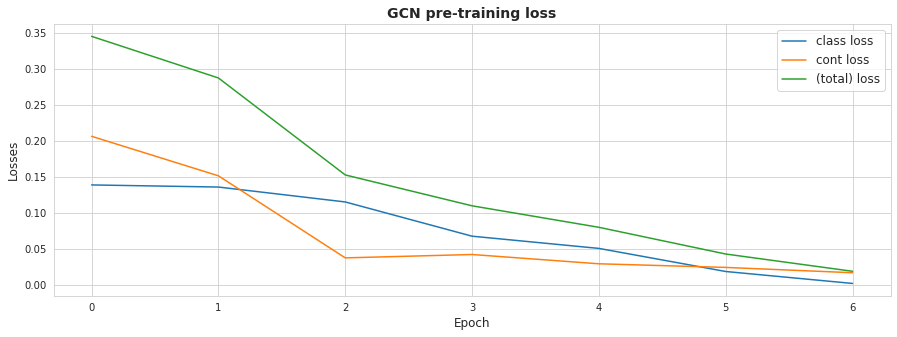

In [23]:
plot_pretraining_progress(experiment_n=2)

We observe the same total loss behavir than before, since we didn't change the number of reconstruction epochs.

### Distribution of generated samples
Let's look at the distribution of the generated samples to see how the generated distributions behaved after 100 epochs of training, every 25 epochs.

#### Distribution of generated angles

Full results not ready yet


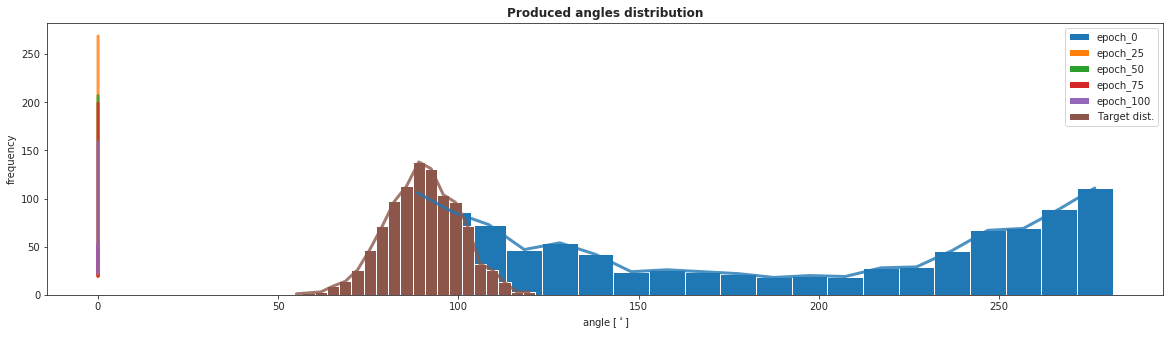

Full results not ready yet


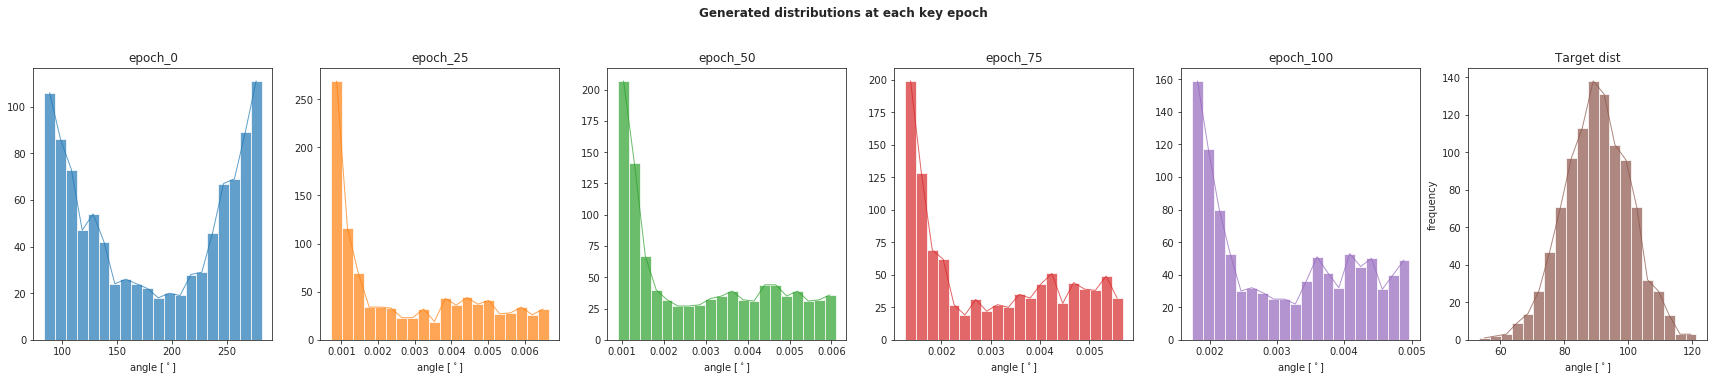

In [21]:
plot_each_distribution(experiment=2, interval=1)

As we can see, the same type of mode collapse is happening, and, since we didn't change the probabilistic grammar, the same type of "inverted Gussian" effect is observed on each distribution. We can further confirm no learning from the generated images.

#### Generated images at each key epoch

Full results not ready yet


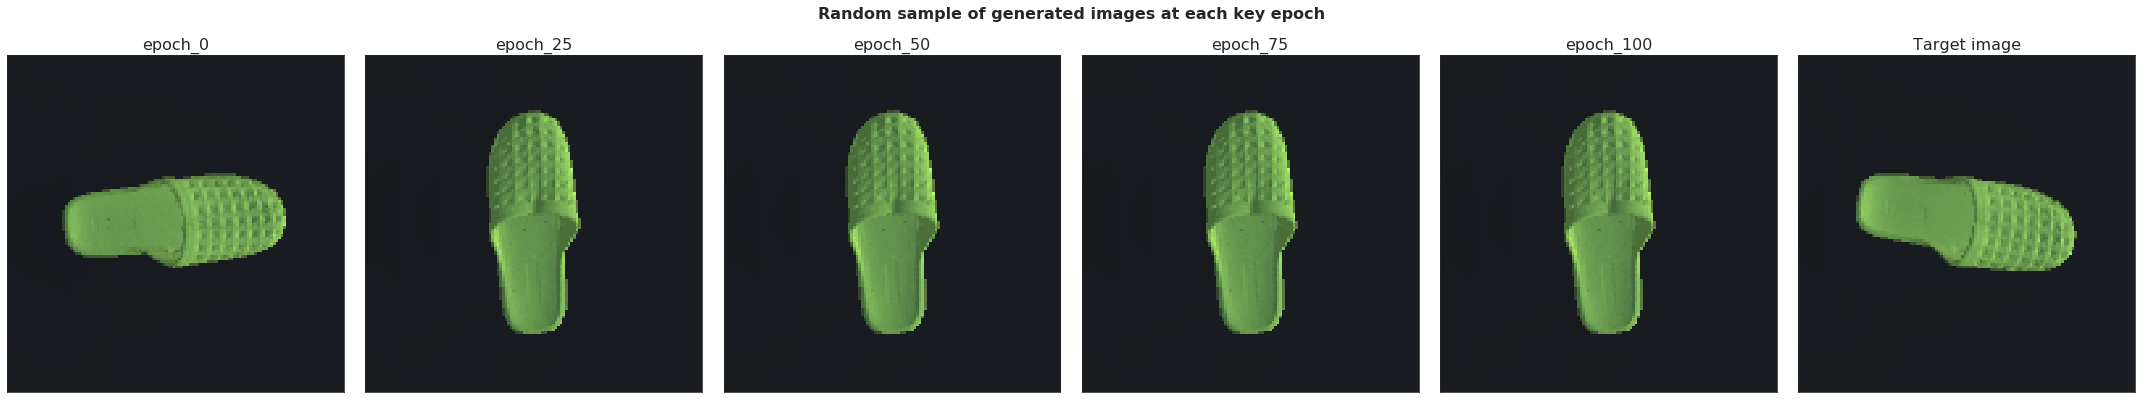

In [41]:
plot_each_image(experiment=2, interval=1)

We can further conclude mode collapse by looking at the MMD loss, and the gradient behavior through the Graph Convolutional Network.

### Maximum Mearn Discrepancy loss and gradient behavior 

#### Maximum Mean Discrepancy loss behavior

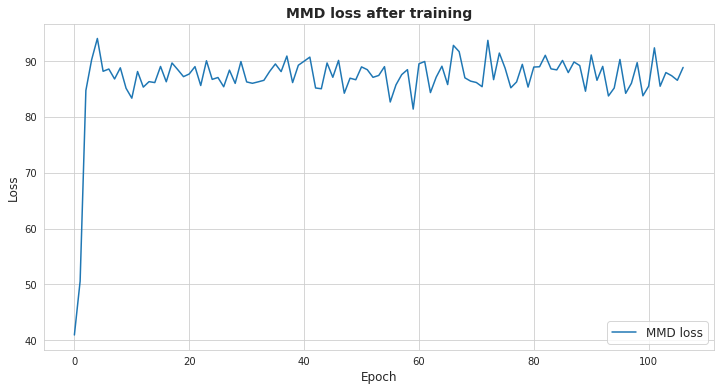

In [36]:
plot_MMD_loss(experiment_n=2)

In this case, the MMD loss seems to have reached a local optimum in a lower loss than the previous experiment, but still a much higher point than desired, and still at angle of 0 degrees.

#### Gradient flow through GCN

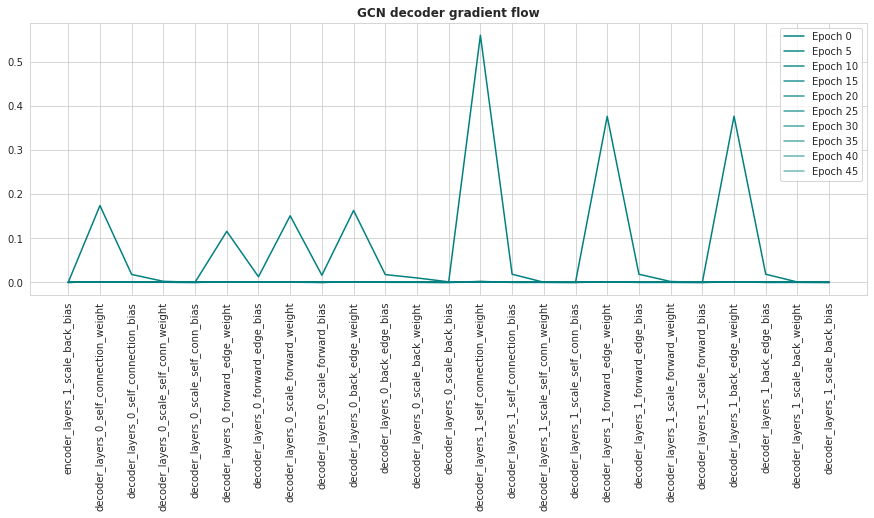

In [39]:
plot_gradients(experiment_n=2)

As we can see, the gradients are collapsing much quicklier this time, compared to the previous experiment. The gradients however, are almost half smaller than the previous experiment. This could be due to the target distribution being much more spread out than the dirac distribution used in the previous experiment. 

Full results not ready yet


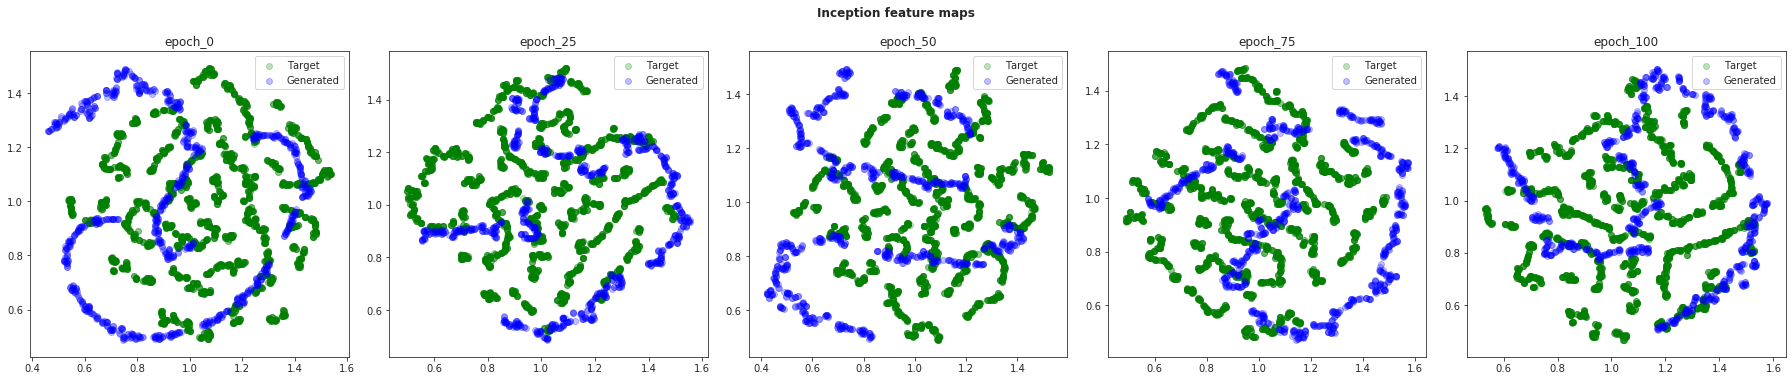

In [55]:
plot_feature_representation(experiment=2, components=2, interval=1)

Full results not ready yet


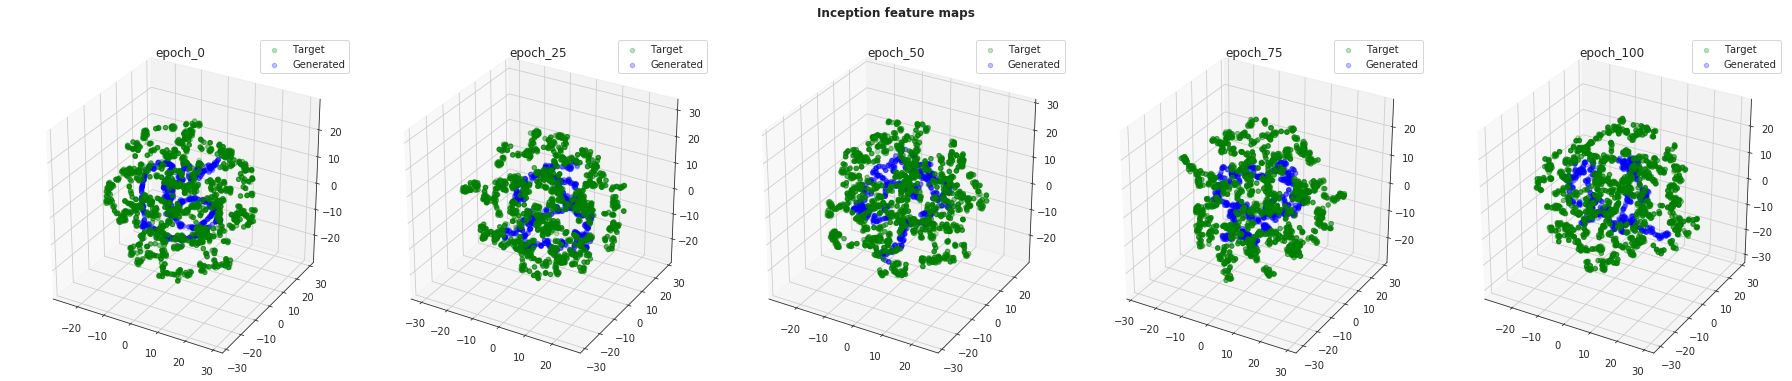

In [56]:
plot_feature_representation(experiment=2, components=3, interval=1)

We can quickly notice that the target distribution feature representation has significantly changed, thanks to the shift from a dirac impulse to a Gaussian distribution. Also, both distributions seem to be in the same general space, compared to the previous with the dirac impulse, where both 3D distributions where completely far from each other. Also, in future experiments we will keep an eye on the number of samples we use for comparison, because we can evidently see that, thanks to the generated batch size of 50, versus the target batch size of 200, there are much more green samples, than blue ones. This must affect the distribution fitting. 

### 4.1.1.3. Fitting a Gaussian ditribution departing from a Gaussian distribution, with 1 pre-training epoch
Given that the previous initial distribution used in the probabilistic grammar provided an inverted Gaussian, we define a new initial distribution of mean 180, standard deviation of 10, and maximum value of 360. This will avoid the modulus effect we observed previously. Additionally, we hypothesize that the GCN pretraining is harmful to the stability of the MMD learning in such a simple case. For this and the past experiment, the graph representation has only 4 nodes, and 9 features, compared to the MNIST case where there are 18 features. We hope that, by pre-training the GCN for 1 epoch, the MMD training will converge towards a sensible mean. We hypothesize this because of the gradient behavior we observed previously, where the gradients are vanishing after just a couple epochs. This means that the MMD learning is getting stuck at a local minimum, and doesn't learn anymore.

### Graph Convolutional Network performance
Since the GCN was only pretrained for 1 epoch, we can look at this single value, and not the plot in itself.

In [3]:
get_GCN_progress(experiment_n=3)

rec_epoch  batch  class_loss  cont_loss      loss
0          0      0    0.138651   0.201646  0.340297

In this case, by leaving a loss at around 0.3 we hope that the architecture will learn more at later stages when trained on the MMD loss.

### Distribution of generated samples
Let's first look at the generated samples to understand whether the architecture is (1) generating Gaussian distributions, and (2), attempting to fit the target distribution.

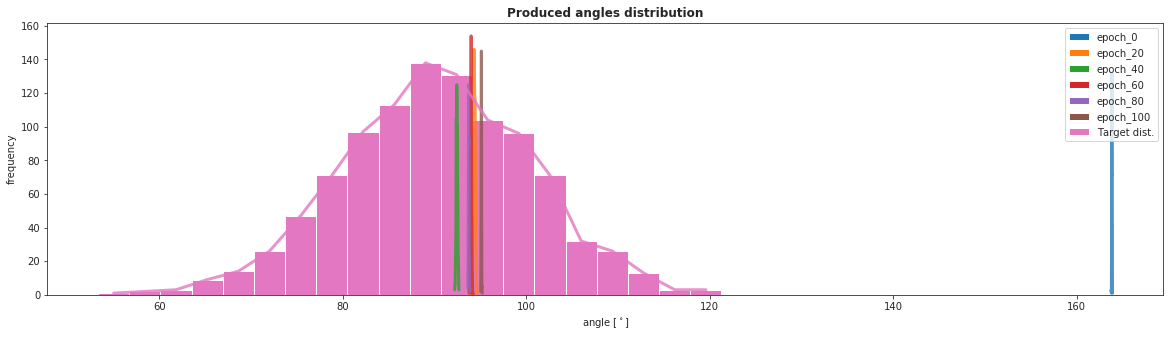

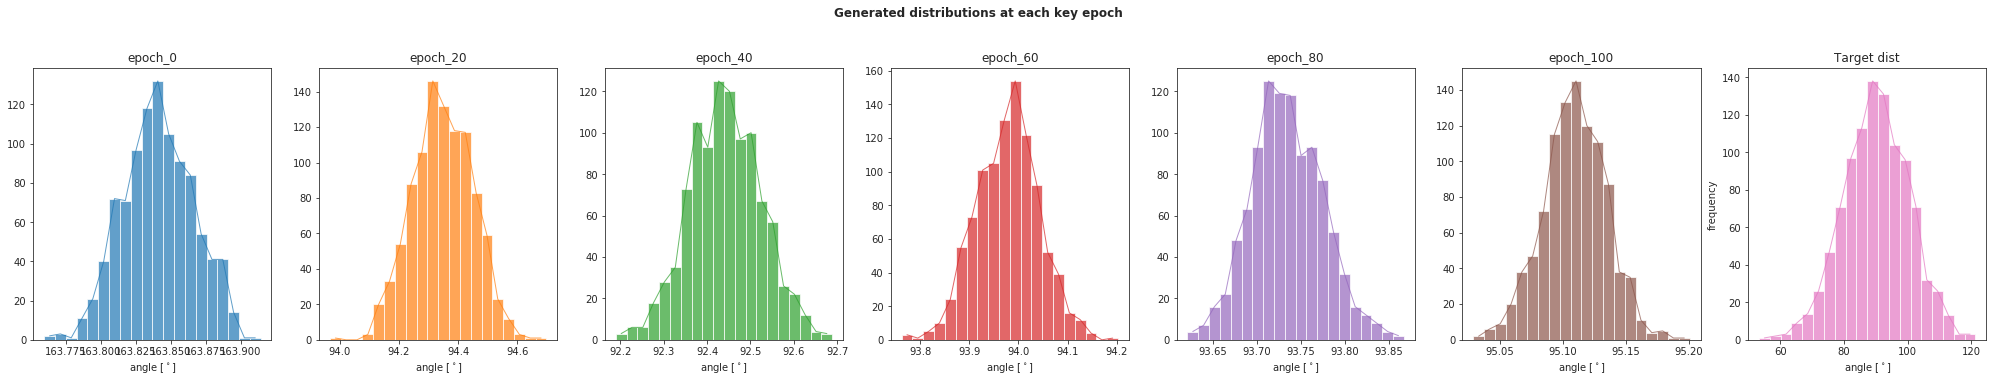

In [16]:
plot_each_distribution(experiment=3, interval=4)

As we can see, the architecture finally attempts to fit the target distribution by shifting its mean from ~165 degrees, to around 90 degrees at epoch 40. This is an important improvement with respect to the previous architecture configurations, since it now learns to generate images that look more like the target ones. We can verify this by looking at the generated images. So what is important here is that the architecture is learning the target mean succesfully. It is not learning the standard deviation of the target distribution, but this is to be expected, according to the paper _give a more thorough explanation of this_.

#### Generated images at each key epoch

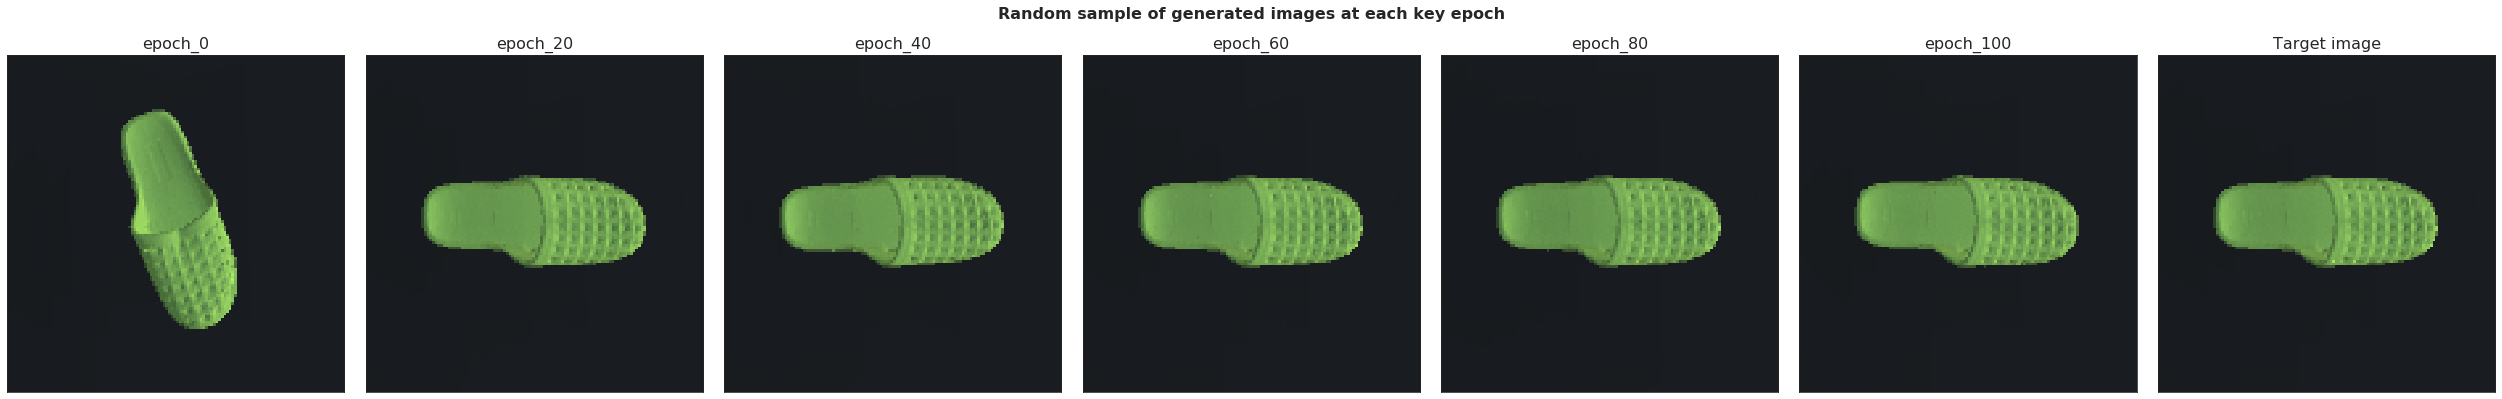

In [21]:
plot_each_image(experiment=3, interval=4)

Indeed, the architecture learns the target angle successfully after 20 epochs, even though it doesn't quite learn the target distribution just yet. We can further confirm learning by plotting the MMD loss, and investigating the gradient flow through the GCN network.

### Maximum Mearn Discrepancy loss and gradient behavior 

#### Maximum Mean Discrepancy loss behavior

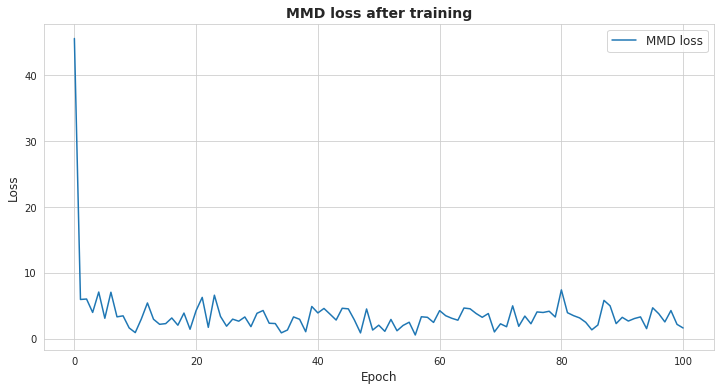

In [25]:
plot_MMD_loss(experiment_n=3)

As we can see, the architecture effectively reduces the loss and finds a local minimum, where the learning seems to be choppy. We can further investigate this by looking at the gradients below, where epoch 0 experiences a high gradient, and therefore the drop in loss above. The learning is indeed choppy in this case, it must have to do with the learning rate, which in this case has no decay and stays at a value of 0.001. In future experiments we will investigate using other learning rate decay values, so the learning is more stable.

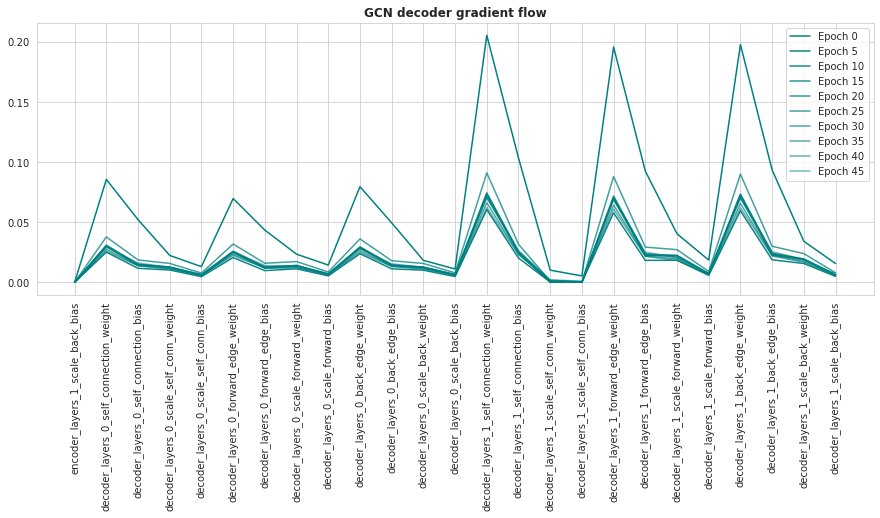

In [31]:
plot_gradients(experiment_n=3)

Indeed, the gradient flow seems much more healthy, where the gradients don't vanish immediately, but there is a gradual convergence towards the local minima located at an angle of ~90 degrees. This configuration seems to be the correct one for this experiment to work. However, this exploration gives us clear evidence that the Meta-Sim architecture is not a very robust architecture when it comes to other custom cases, different than the MNIST case.

### Distribution of Inception feature maps

#### Per epoch feature representation in 2D

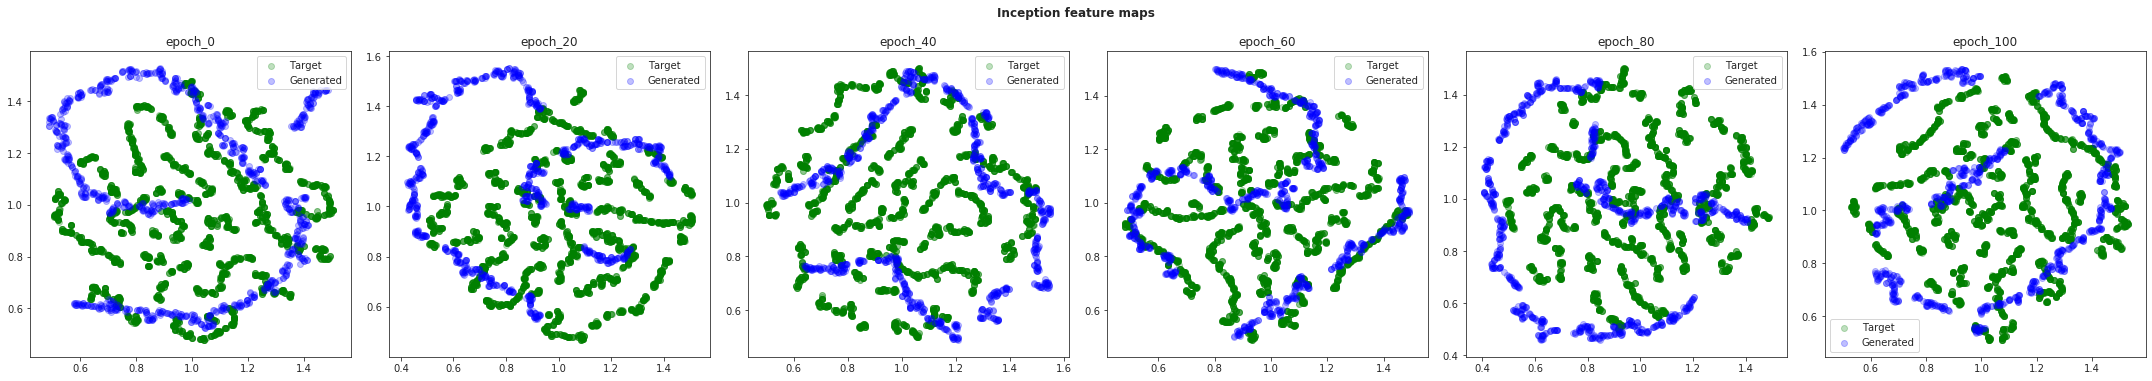

In [57]:
plot_feature_representation(experiment=3, components=2, interval=4)

#### Per epoch feature representation in 3D

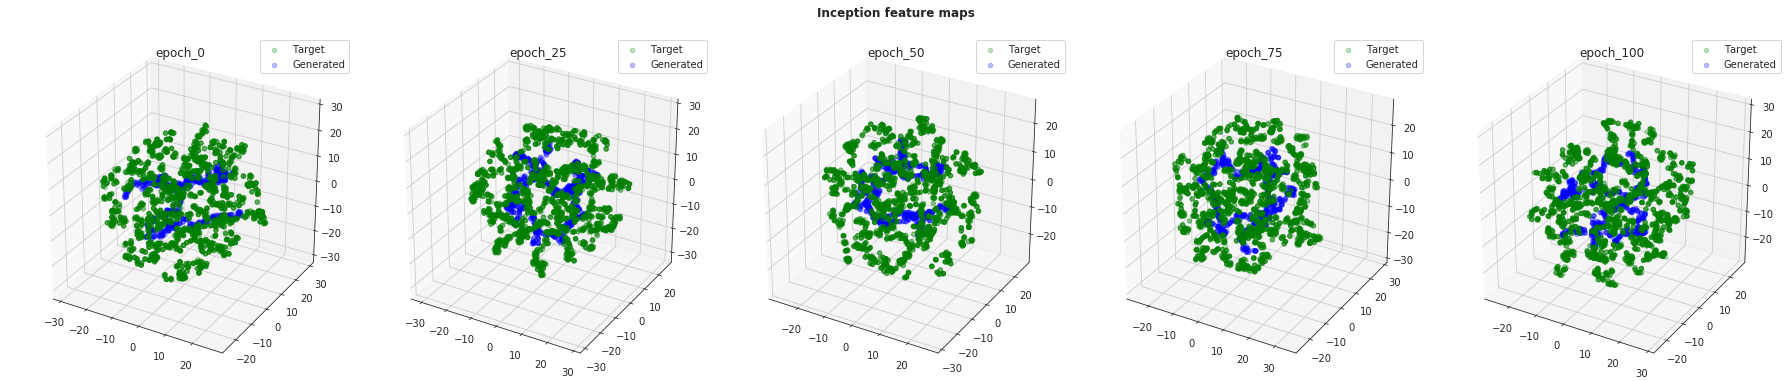

In [58]:
plot_feature_representation(experiment=3, components=3, interval=5)

The distribution of feature maps doesn't seem to show the clear improvement in performance that the MMD and images showed. In the 2D representation there seems to be more overlap with respect to the previous experiment, but no clear, aparent change is evident. Maybe we can move to representing the feature maps with a different method than T-SNE such as local linear embbedding (reference paper). T-SNE seems to be good for differentiating among classes, but not for fine grained distribution, or distance representation. We could also, actually use PCA.

### 4.1.1.4. Attempting to widen the generated distribution 
As we saw from the previous experiment, the architecture is indeed learning a sensible mean of the target distribution, but it isn't learning, or even generating a distribution with a wider standard deviation. We will attempt multiple strategies in the hopes of the architecture learning to generate a wider distribution centered around ~90 degrees.

### 4.1.1.4.1. Increasing the number of pre-training epochs
According to the paper, and to previous experiments, it is indeed evident that it is during the pre-training phase that the GCN learns to generate a wider distribution, which is the one specified in the probabilistic grammar. This however, in our case, has shown to unstabilize learning of the target mean. In this set of experiments we gradually increase the number of reconstruction epochs to widen the generated distribution, while trying to learn the correct mean.

### Using 5 reconstruction epochs
We will start by increasing the number of reconstruction epochs to 5, and we leave all other hyperparameters as per the experiment in the previous section. We hope that, by increasing the number of pre-training epochs, the architecture learns to generate the distribution specified in the probabilistic grammar.

Let's start by looking into the pre-training loss. The following plot shows that the GCN is succesfully learning to reconstruct the graphs sampled from the grammar.

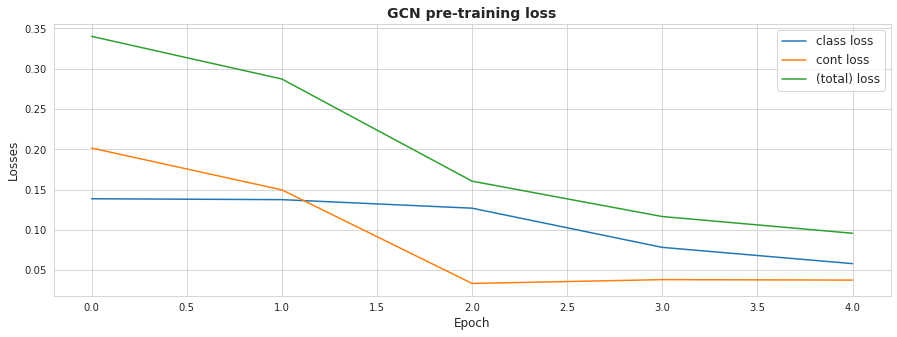

In [81]:
plot_pretraining_progress(experiment_n=4)

If we now plot the generated distributions after training, we can see that the learned distribution is not clear. However, we can see that the architecture is generating a gaussian, as opposed to the previous experiments where the architecture was only generating a pulse around a mean.

Full results not ready yet


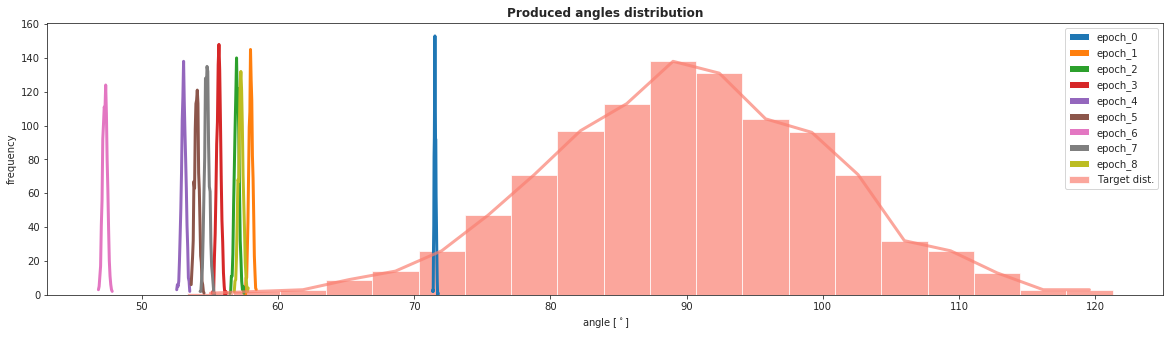

Full results not ready yet


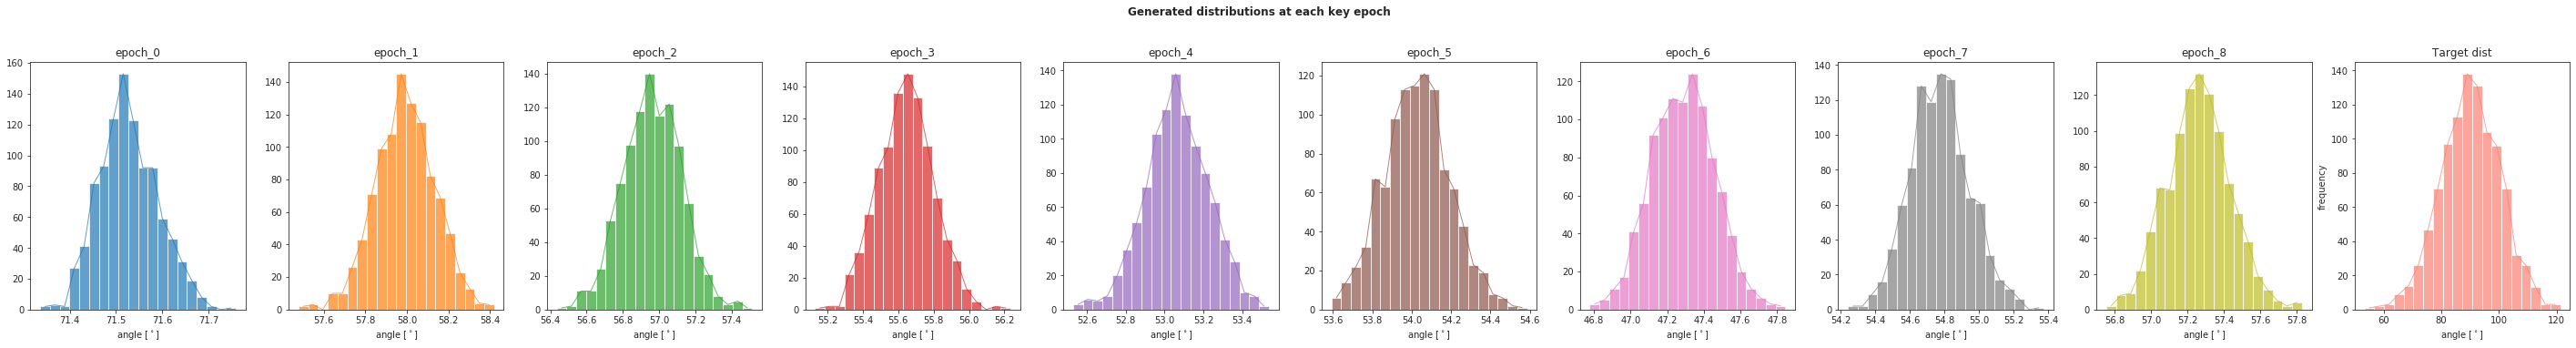

In [82]:
plot_each_distribution(experiment=4, interval=1)

The architecture indeed seems not to be learning, this may be due to very large gradients. Let's look at the MMD loss first in the following plot. Here we can see that indeed the loss is very erratic and incosistent, there seems to be no convergence. This may be due to our learning rate being too large, or because there is no learning rate decay.

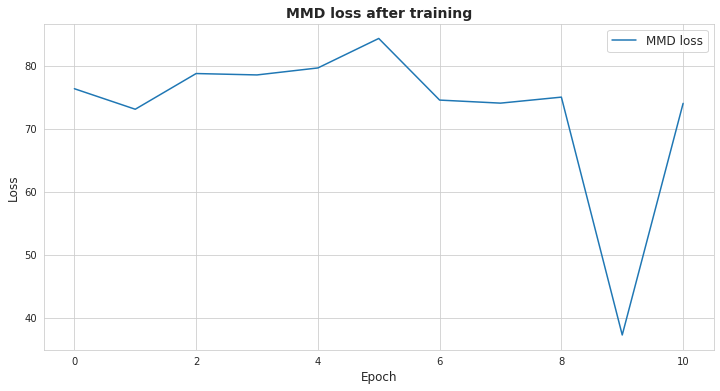

In [86]:
plot_MMD_loss(experiment_n=4)

If we look at the gradients, there seems to be no apparent vanishing gradient problem. In fact, the gradients seem to be healthier than the ones in our previous experiment. This may indicate that with this pre-training configuration, the architecture can learn, but the updates are too large, and therefore the learning is unstable. In later experiments, we may try to (1) reduce the learning rate we are using, and (2) implement learning rate decay.

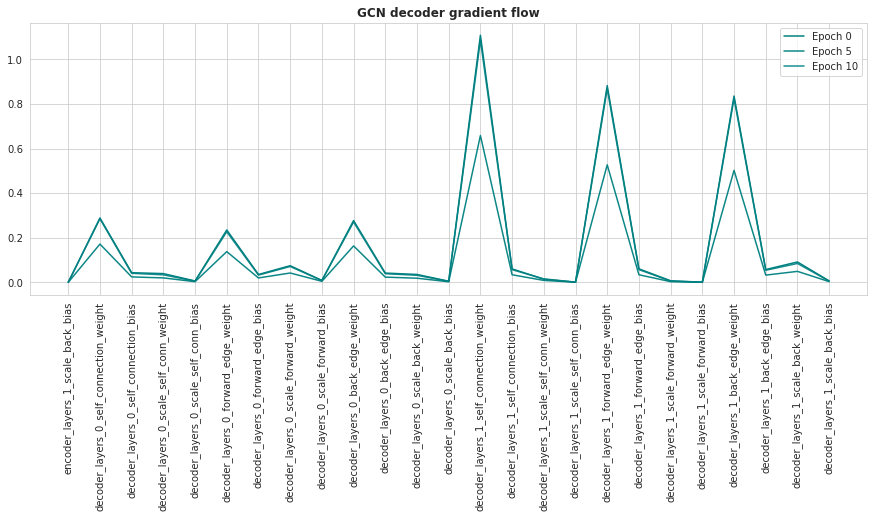

In [85]:
plot_gradients(experiment_n=4)

### Using 10 reconstruction epochs
We will start by increasing the number of reconstruction epochs to 10, and we leave all other hyperparameters as per the experiment in the previous section.

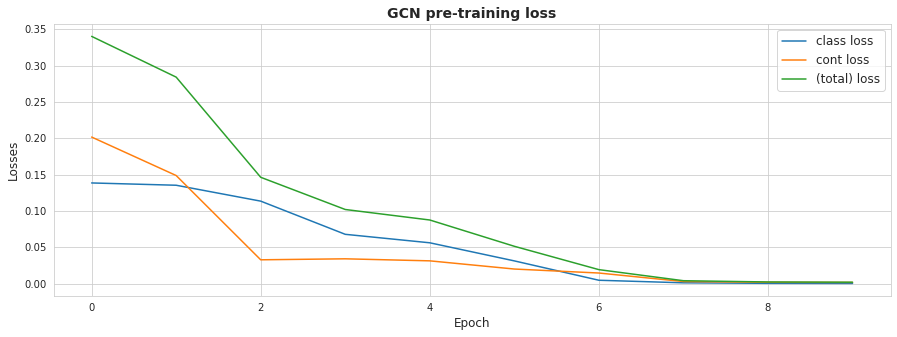

In [89]:
plot_pretraining_progress(experiment_n=5)

Full results not ready yet


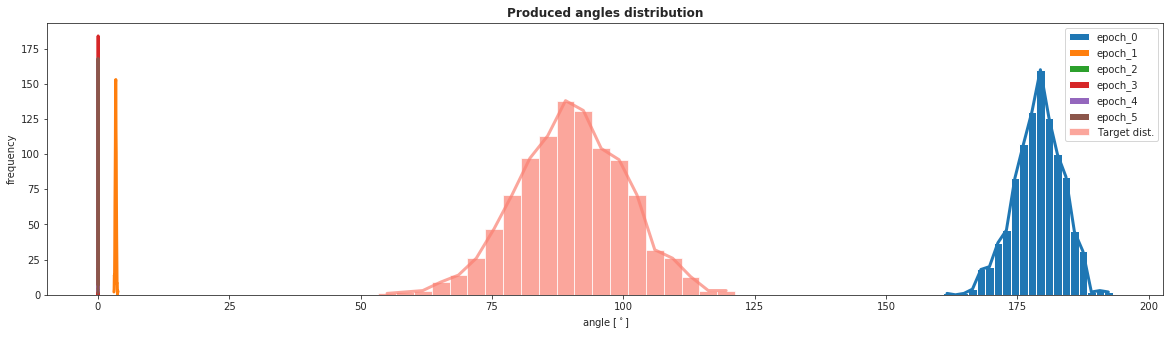

Full results not ready yet


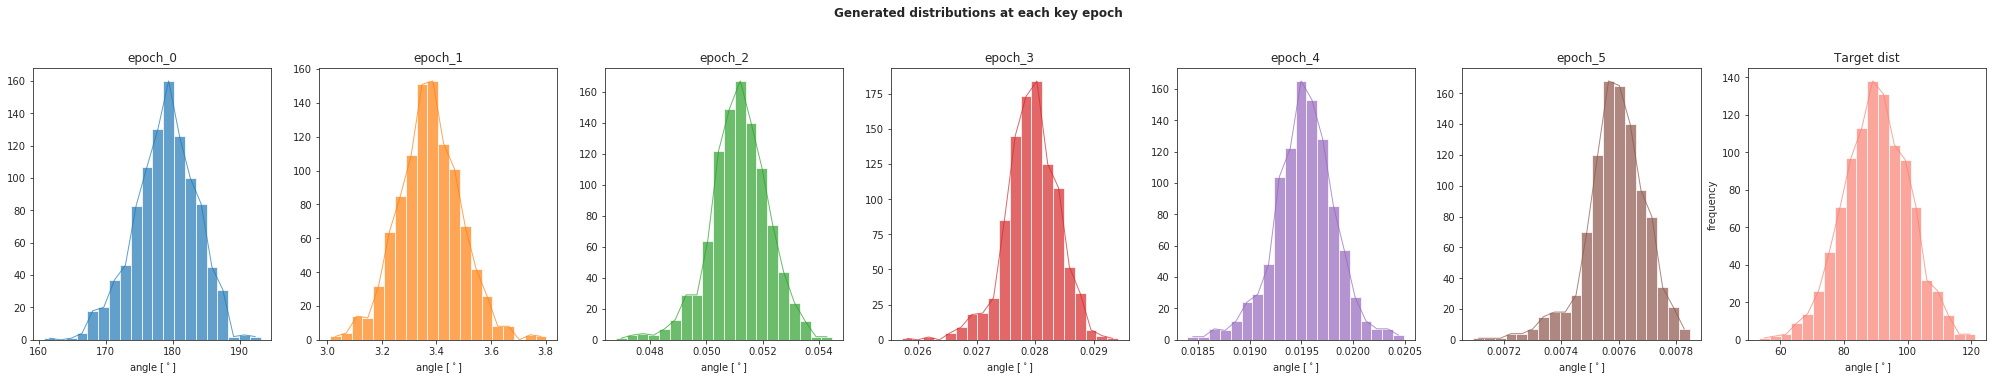

In [90]:
plot_each_distribution(experiment=5, interval=1)

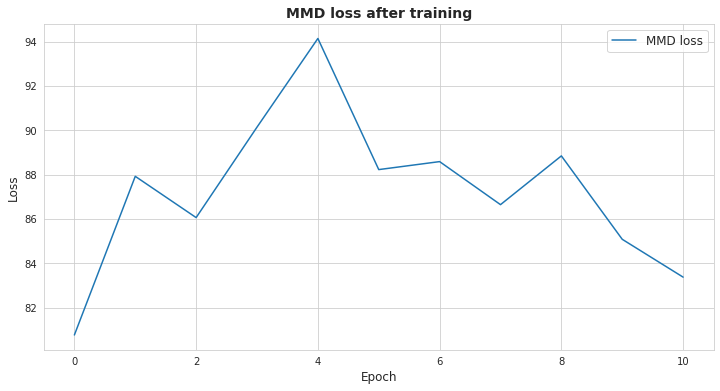

In [95]:
plot_MMD_loss(experiment_n=5)

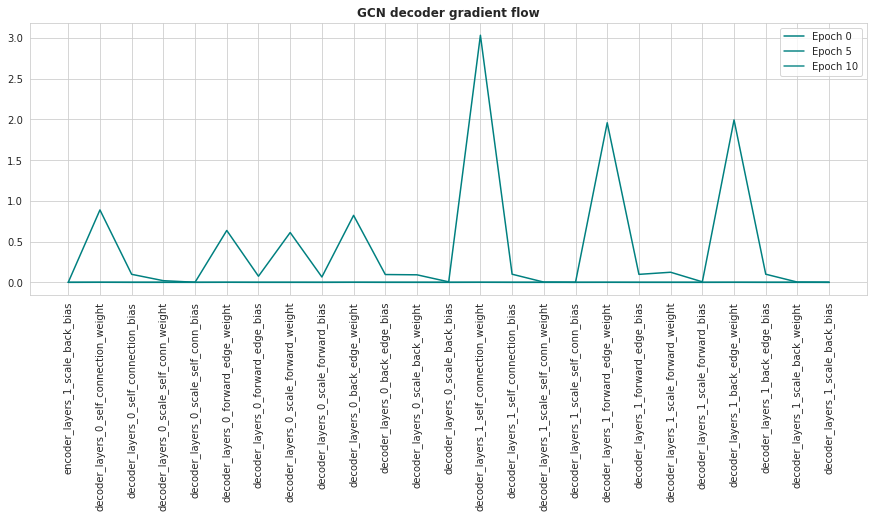

In [96]:
plot_gradients(experiment_n=5)

### Using 15 reconstruction epochs
We will start by increasing the number of reconstruction epochs to 2, and we leave all other hyperparameters as per the experiment in the previous section.

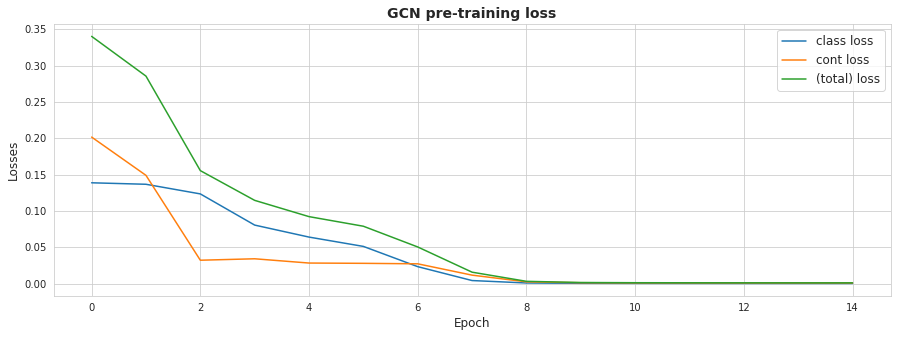

In [98]:
plot_pretraining_progress(experiment_n=6)

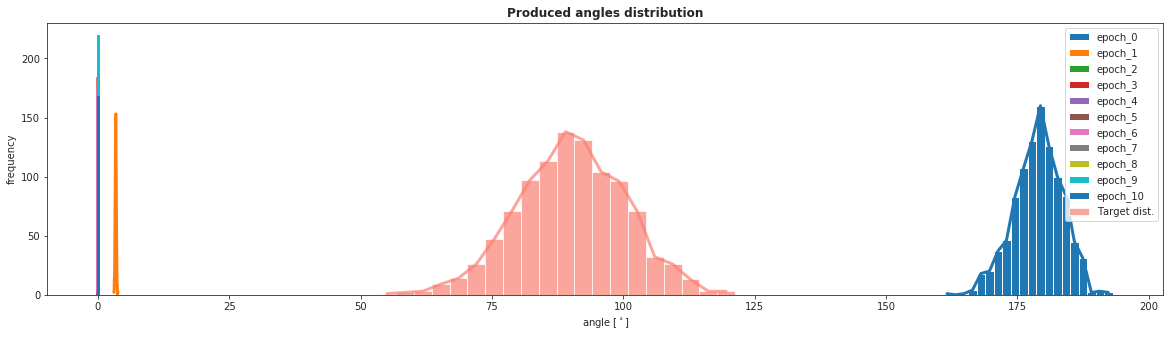

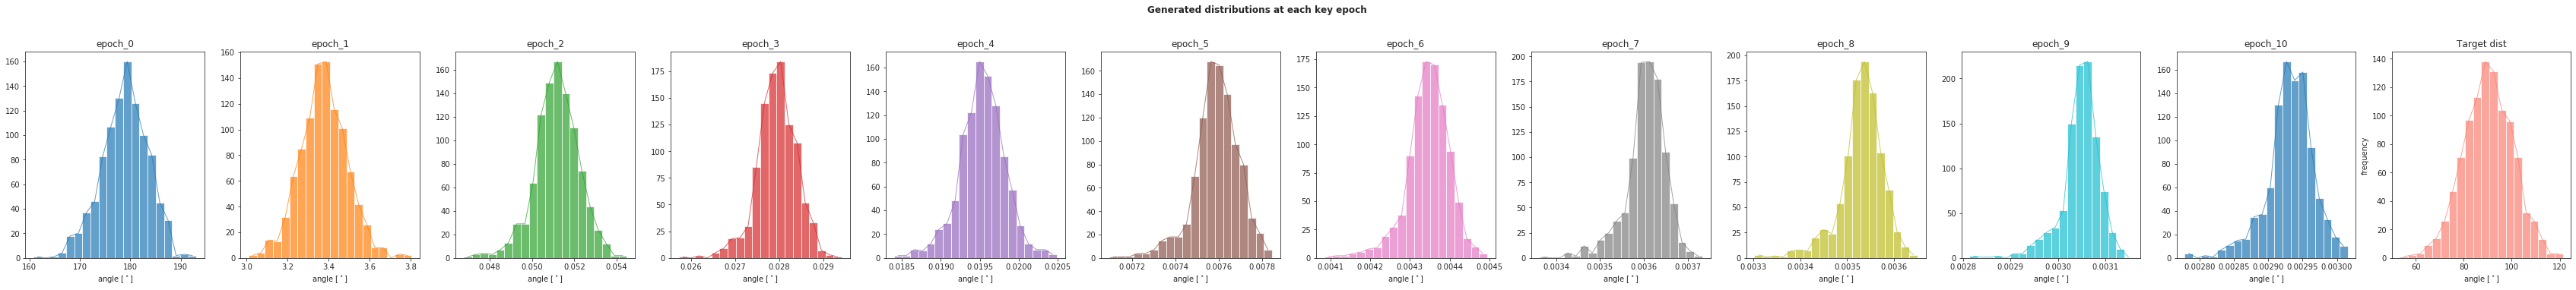

In [99]:
plot_each_distribution(experiment=6, interval=1)

### 4.1.1.4.2. Increasing the number of pre-training epochs and employing learning rate decay
According to the paper, and to previous experiments, it is indeed evident that it is during the pre-training phase that the GCN learns to generate a wider distribution, which is the one specified in the probabilistic grammar. This however, in our case, has shown to unstabilize learning of the target mean. In this set of experiments we gradually increase the number of reconstruction epochs to widen the generated distribution, while learning the correct mean.

### Using 5 reconstruction epochs
We will start by increasing the number of reconstruction epochs to 2, and we leave all other hyperparameters as per the experiment in the previous section.

### Using 10 reconstruction epochs
We will start by increasing the number of reconstruction epochs to 2, and we leave all other hyperparameters as per the experiment in the previous section.

### Using 15 reconstruction epochs
We will start by increasing the number of reconstruction epochs to 2, and we leave all other hyperparameters as per the experiment in the previous section.

## 4.1.2. Learning to rotate and translate an object on a single-class setting
In our case, the random distribution will be a set of images from an object in a Unity 3D scene rotated according to a prior normal distribution of arbitrary parameters, and the fixed (target) distribution will be a set of images from the same object in the 3D scene rotated 90 degrees. The graph representation of the probabilistic grammar used for this set of experiments is shown below _show graph figure of probabilistic grammar_.

### 4.1.2.1. Increasing the number of mutable attributes to 2
We increase the number of mutable attributes to 2: yaw, loc_x, and we perform an initial experiment where we keep the generated values deterministic, so the only new representation that is being learned is a more complex graph representation, but no changes to the generated image distribution is being made. 

This way the only attribute whose distribution remains non-deterministic is the yaw parameter. We train a model for 10 epochs to learn this target distribution on the modfied grammar.

In [48]:
Add experiment here

SyntaxError: invalid syntax (<ipython-input-48-2305bc096c6e>, line 1)

### 4.1.2.2. Increasing the number of mutable attributes to 3
We increase the number of mutable attributes to 2: yaw, loc_x, loc_y, and we perform an initial experiment where we keep the generated values deterministic, so the only new representation that is being learned is a more complex graph representation, but no changes to the generated image distribution is being made. 

This way the only attribute whose distribution remains non-deterministic is the yaw parameter. We train a model for 10 epochs to learn this target distribution on the modfied grammar.

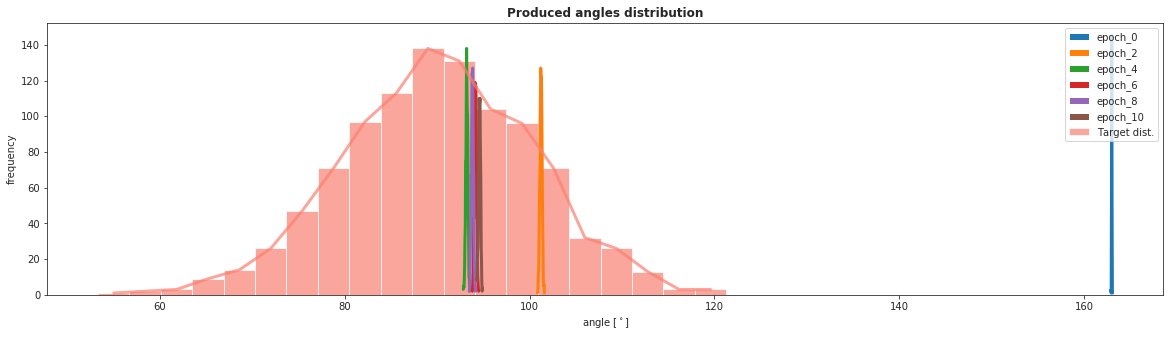

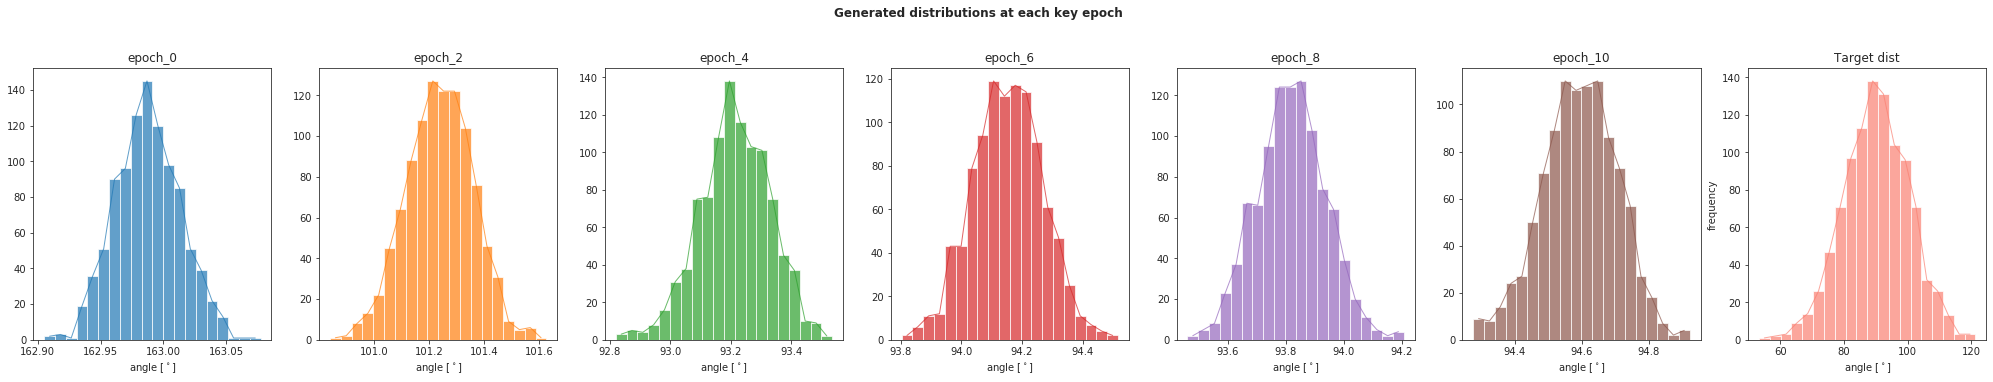

In [21]:
plot_each_distribution(experiment=17, interval=1)

Indeed, the architecture is still not learning to generate the target wider distribution, due to the initial experiment being pre-trained for only 1 epoch. In this case however, the architecture does learn the approximate mean of the target distribution. Let's observe the generated images every 2 epochs of training.

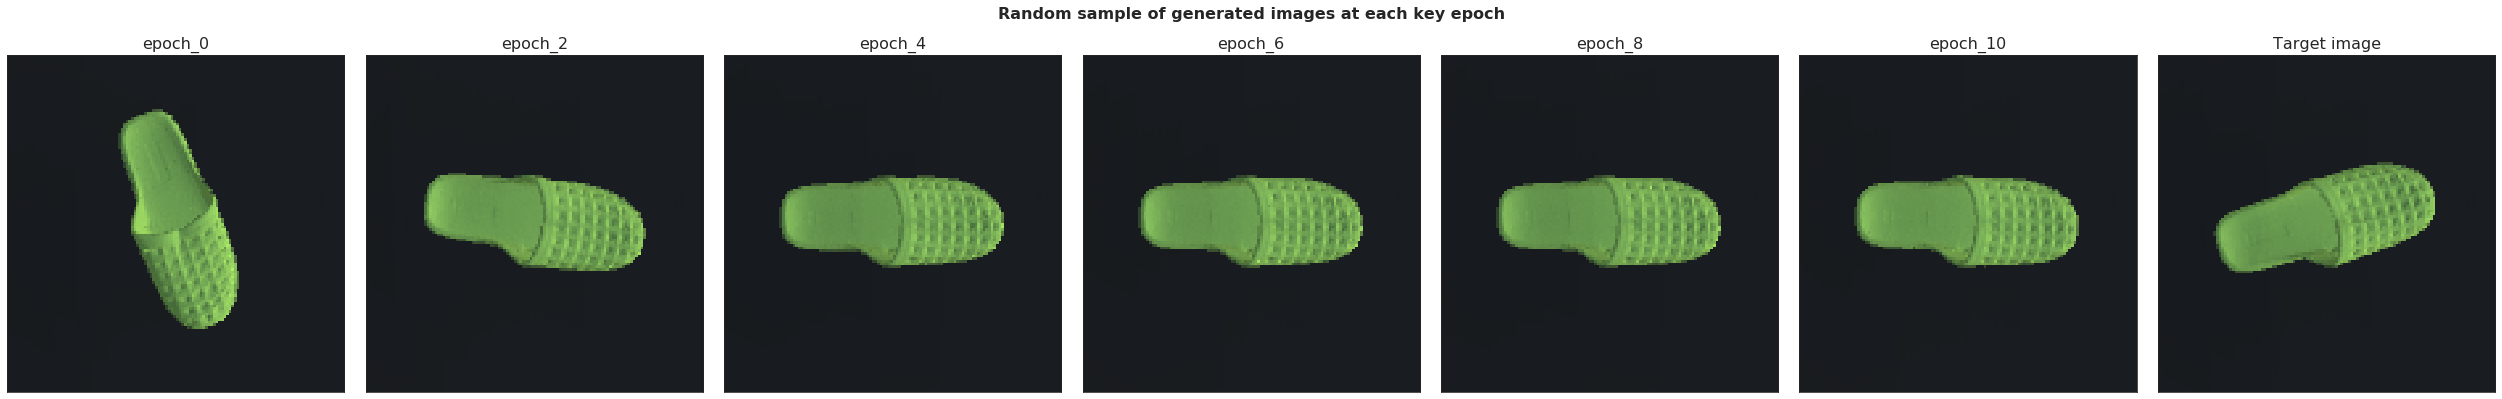

In [47]:
plot_each_image(experiment=17, interval=1)

We now change the probabilistic grammar to allow to generate a distribution of values for the loc_x and loc_y attributes. And we also define a new target distribution for each of these 2 attributes, from which images are generated as well. The generated graphs now will be passed to the rendering engine, and the rendering engine will manipulate the 3 attributes to generate images that hopefully match the target distributions.

## DISCARDED RESULTS

In [52]:
get_GCN_progress(experiment_n=7) # this has dropout, we need to re-do 

rec_epoch  batch  class_loss  cont_loss      loss
0          0      0    0.138882   0.201371  0.340253
1          1      0    0.136214   0.145976  0.282190

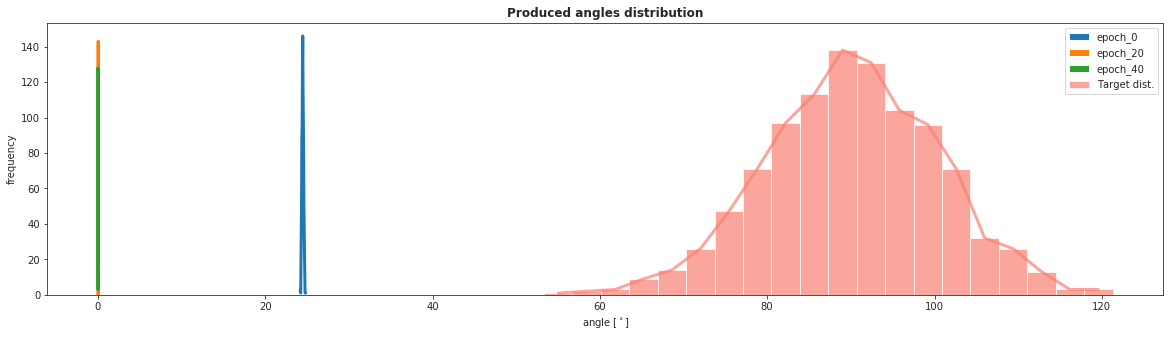

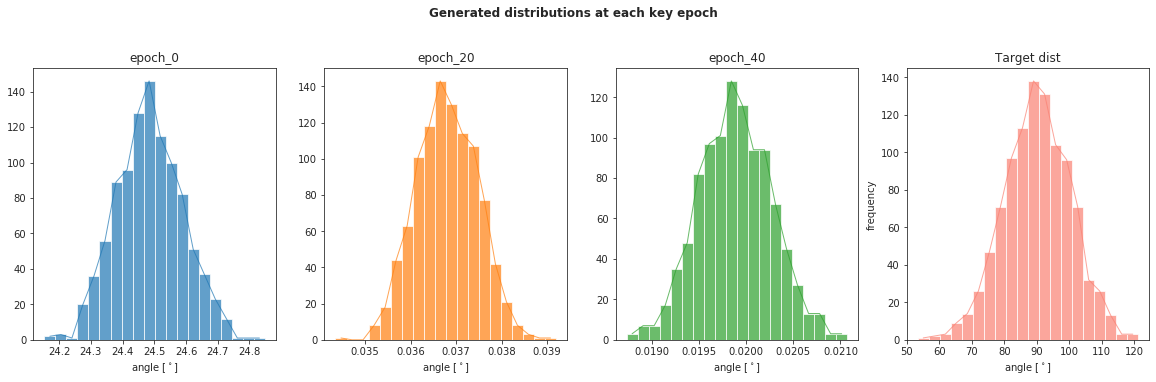

In [28]:
plot_each_distribution(experiment=7, interval=4)

As we can see from the distributions, this is not enough for the architecture to properly learn to generate a wider distribution. We will therefore experiment with more reconstruction epochs, as 2 is not enough.

### Using 5 reconstruction epochs
Since after 2 pre-training epochs no distribution was learned, we decide to increase this number to 15, with the hopes of the architecture learning to produce the pre-specified distribution of angles from the probabilistic grammar. We first plot the pre-training loss, and we observe that, after 8 reconstruction epoch, the total loss is nearly 0.

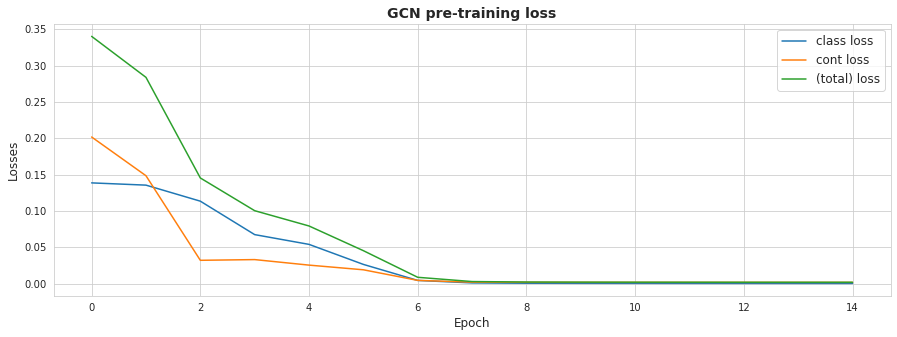

In [42]:
plot_pretraining_progress(experiment_n=11)

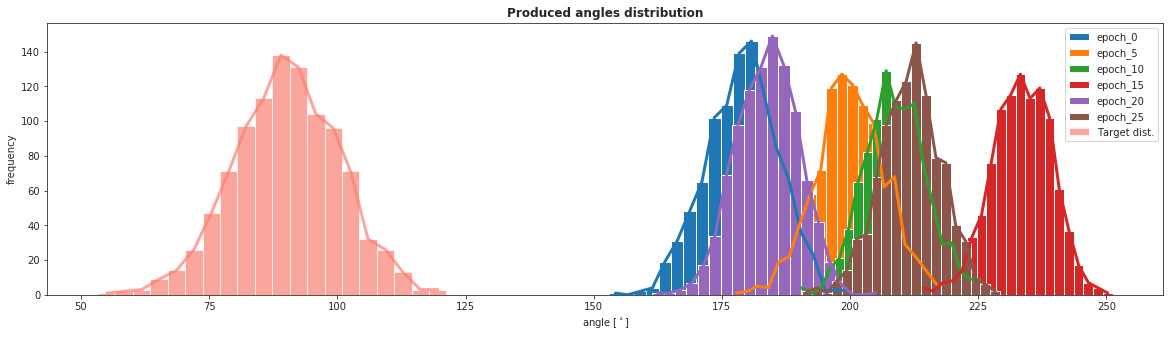

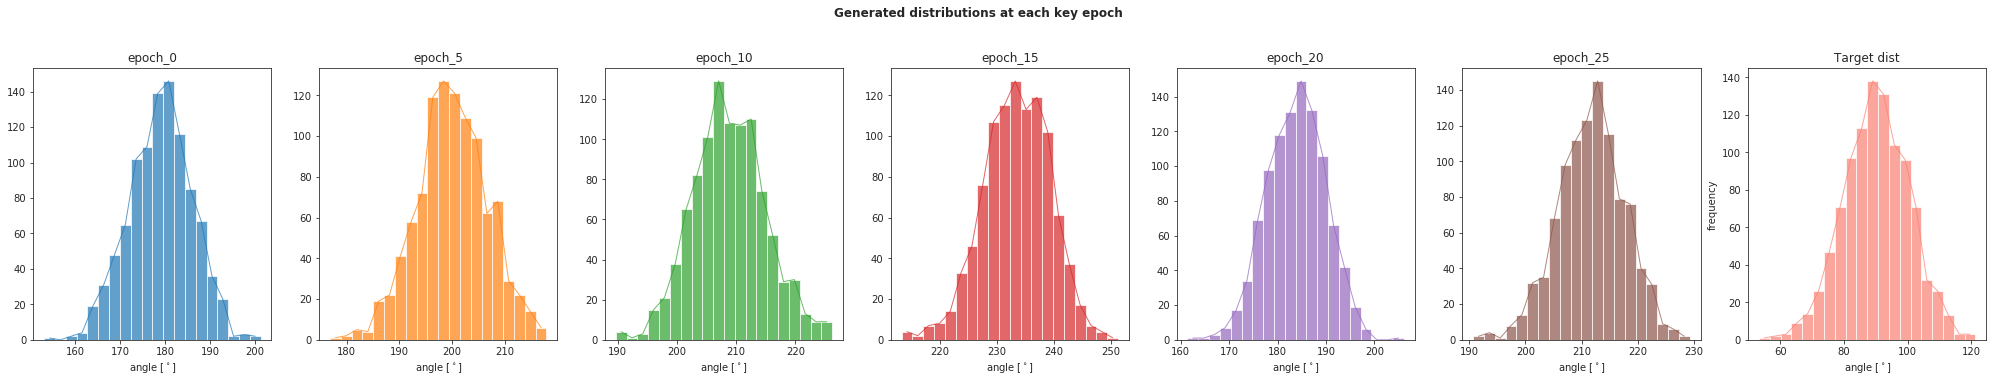

In [39]:
plot_each_distribution(experiment=11, interval=1)

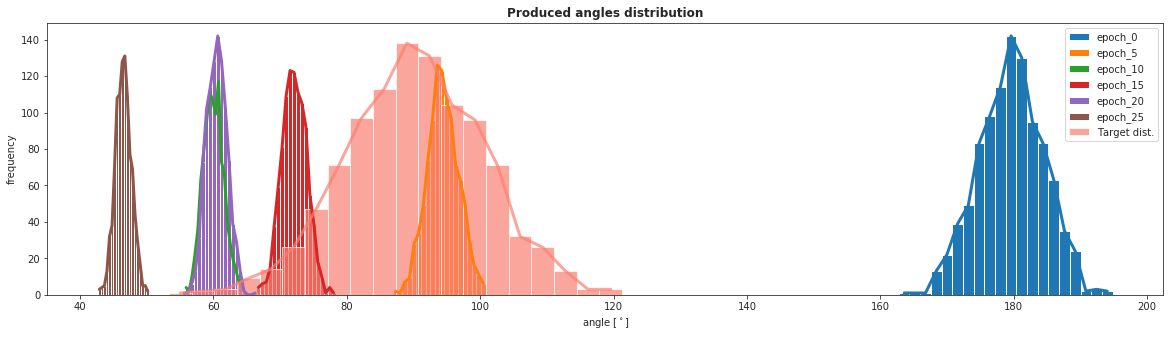

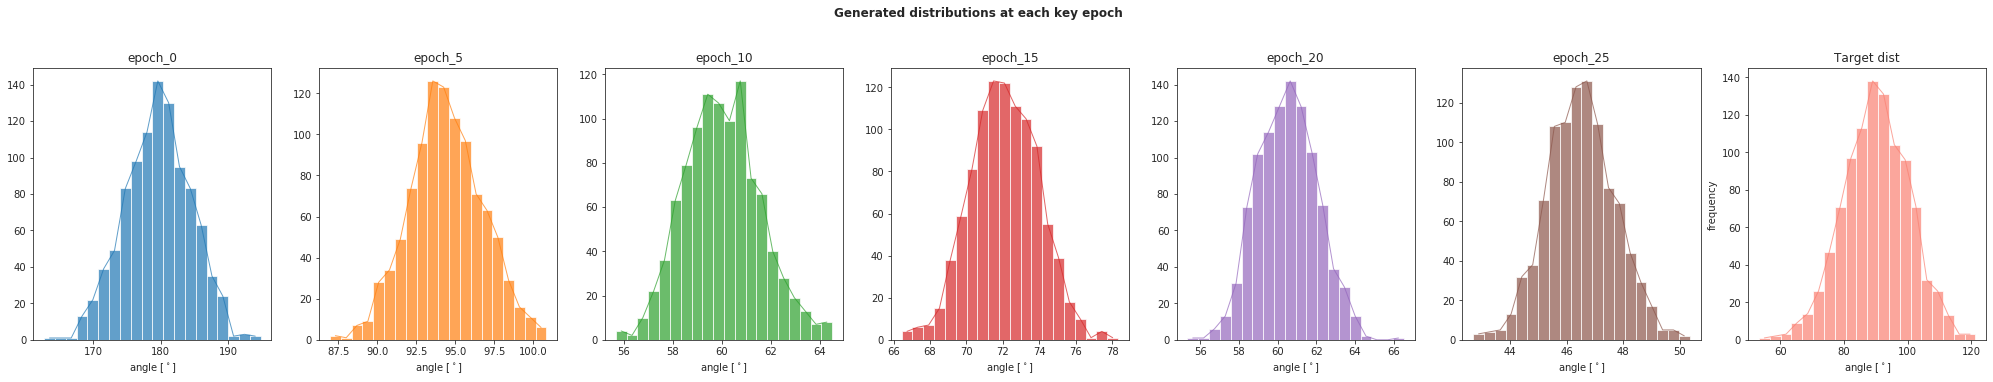

In [37]:
plot_each_distribution(experiment=12, interval=1)

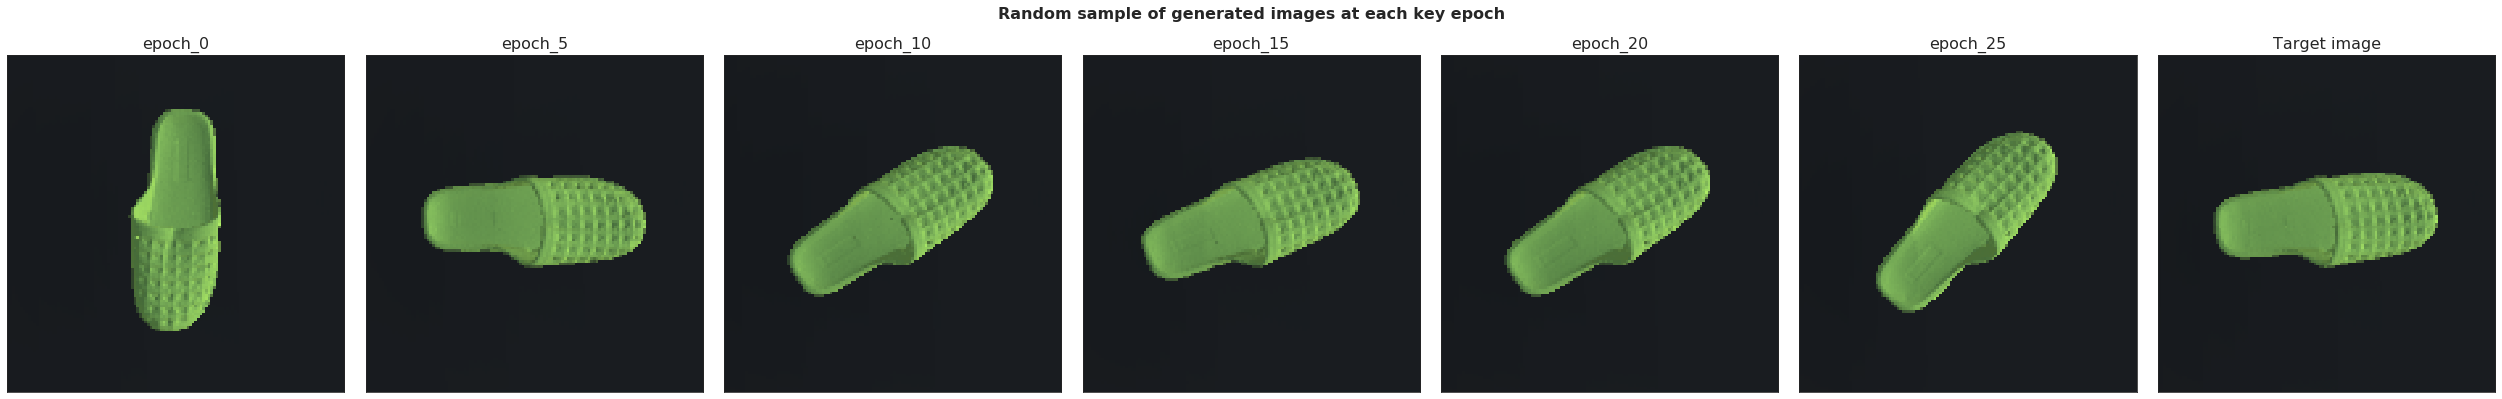

In [10]:
plot_each_image(experiment=12, interval=1)

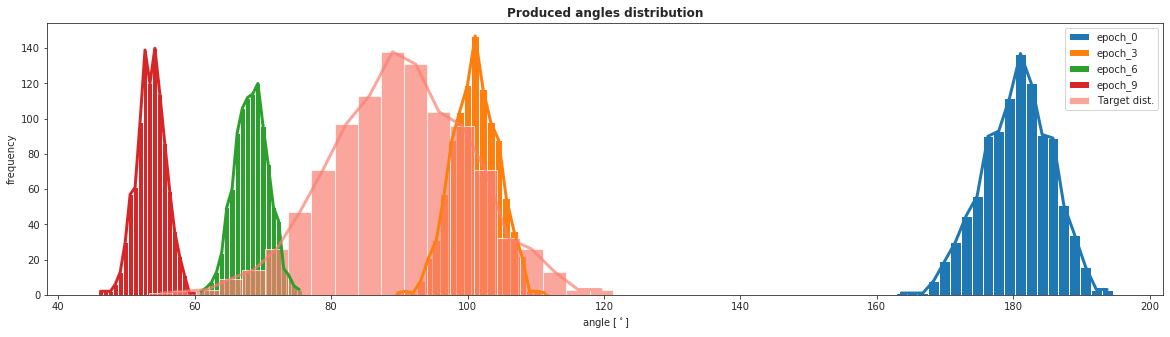

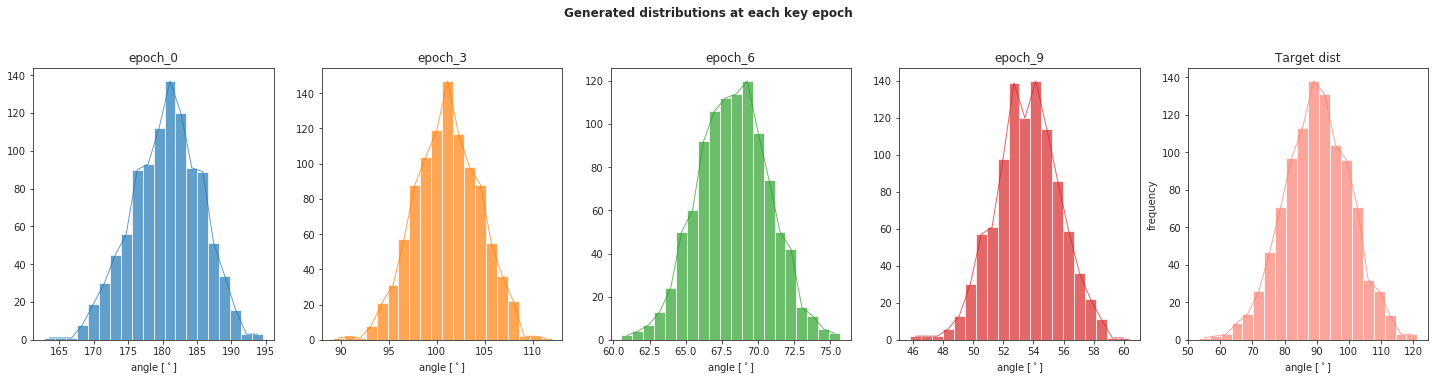

In [11]:
plot_each_distribution(experiment=13, interval=3)

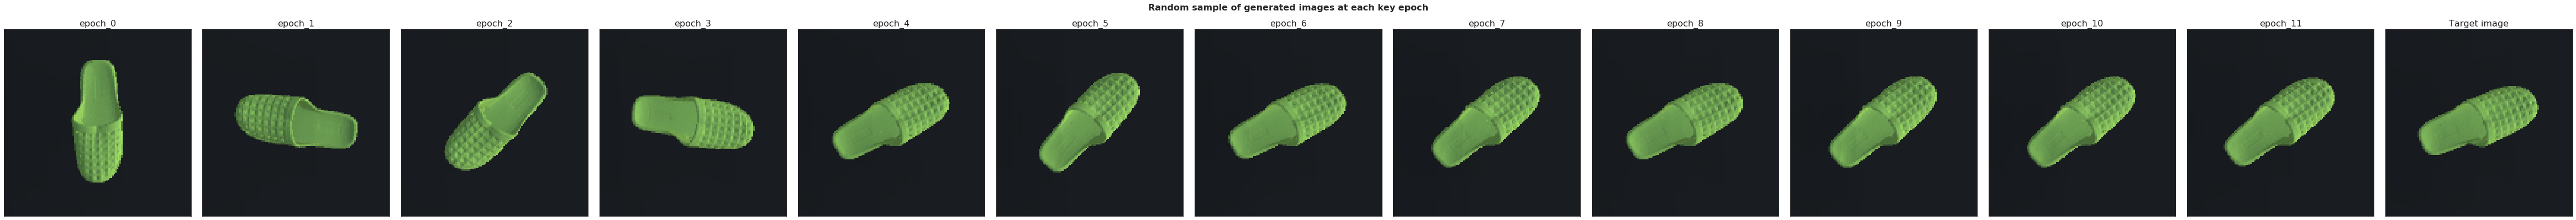

In [12]:
plot_each_image(experiment=13, interval=1)